In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS
from qs_mps.utils import anim

# Periodic Boundary Condition Time Evolution

We are going to check the validity of the MPO for time evolution with the pbc hamiltonian. Hence, we are going to perform exact diagonalization with sparse matrices and compare the results.

## 1. Exact Time Evolution

We are going to perform two types of evolution:
- a. Start with the vacuum in the roughening, apply a string operator, evolve with the same hamiltonian
- b. Start with the string in the confined, evolve with the hamiltonian in the roughening region

### 1.a.1 Dual Hamiltonian in the vacuum roughening region

In [49]:
def charge_func(i: int, j: int, l: int, cx: list=None, cy: list=None):
    if cx is not None and cy is not None:
        if i >= cx[0] and i < cx[1] and (j+1)%l == cy[0]:
            return -1
        else:
            return 1
    else:
        return 1
        
def electric_dual_ham(l: int, L: int, cx: list=None, cy: list=None):
    dof = l*L + 1
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O

    # charges
    charges = np.ones((l,L+1))
    if cx is not None:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1

    prod_charges = np.prod(charges, axis=1).tolist()

    # first column of sigmas are local
    for j in range(l):
        H_sigmas += sparse_pauli_z(n=j*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        # H_sigmas += sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for i in range(L):
        for j in range(l):
            # coeff = charge_func(i,j,l,cx,cy)
            # H_taus += coeff * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)
            H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)

    return H_sigmas + H_taus

def magnetic_dual_ham(l: int, L: int):
    dof = l*L + 1
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_plaquettes = O

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)
    return H_plaquettes

def dual_ham(l,L,g, cx: list=None, cy: list=None):
    # electric vertical and horizontal terms
    H_el = electric_dual_ham(l,L,cx,cy)

    # magnetic plaquette terms
    H_mag = magnetic_dual_ham(l,L)

    return - g * H_el - 1/g * H_mag

def electric_field(l: int, L: int, statevector: np.ndarray, cx: list=[], cy: list=[]):
    dof = l*L + 1
    exp_sigmas = []
    exp_taus = []

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()

    # first column of sigma are local
    for j in range(l):
        # H_sigmas += sparse_pauli_z(n=j*L, L=dof)
        exp_sigmas.append(statevector.T.conjugate() @ sparse_pauli_z(n=j*L, L=dof) @ statevector)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            # H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)
            exp_sigmas.append(statevector.T.conjugate() @ sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof) @ statevector)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        # H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)
        exp_sigmas.append(np.prod(prod_charges[:(j+1)]) * (statevector.T.conjugate() @ sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof) @ statevector))

    # vertical zz interactions 
    for i in range(L):
        for j in range(l):
            # H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)
            exp_taus.append(np.prod(charges[(j+1)%l,:(i+1)]) * (statevector.T.conjugate() @ sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof) @ statevector))
    
    exp_sigmas_l = np.asarray(exp_sigmas[:l]).reshape((l,1))
    exp_sigmas_b = np.asarray(exp_sigmas[l:-l]).reshape((l,(L+1)-2))
    exp_sigmas_r = np.asarray(exp_sigmas[-l:]).reshape((l,1))
    exp_ver = [[exp_sigmas_l[i]]+[exp_sigmas_b[i]]+[exp_sigmas_r[i]] for i in range(l)]
    exp_ver_swaped = []
    for row in exp_ver:
        for elem in row:
            if len(elem) == 1:
                exp_ver_swaped += (elem.real).tolist()
            else:
                exp_ver_swaped += (elem.real).tolist()
    exp_hor = np.array(exp_taus).reshape((L,l))
    exp_hor_swaped = exp_hor.swapaxes(0,1)
    exp_hor_swaped[[0,-1]] = exp_hor_swaped[[-1,0]]
    exp_val = np.zeros((2*l,2*L+1))
    exp_val[:] = np.nan
    exp_val[1::2,::2] = np.asarray(exp_ver_swaped).reshape((l,L+1))
    exp_val[::2,1::2] = np.asarray(exp_hor_swaped).reshape((l,L))
    
    return exp_val

In [50]:
l = 2
L = 3
g = 10
H_vr = dual_ham(l,L,g)
e, psi0 = diagonalization(H_vr, sparse=True)
print(len(e),psi0.shape, e)

1 (128, 1) [-140.00075]


In [51]:
# charges
cx = [1,2]
cy = [0,0]
charges = np.ones((l,L+1))
if len(cx) != 0:
    charges[cy[0],cx[0]] = -1
    charges[cy[1],cx[1]] = -1
prod_charges = np.prod(charges, axis=1).tolist()
print(charges)
print(prod_charges)
i = 1
j = 3
print(charges[(i+1)%l,:(j+1)])

[[ 1. -1. -1.  1.]
 [ 1.  1.  1.  1.]]
[1.0, 1.0]
[ 1. -1. -1.  1.]


In [52]:
i = 1
j = 1
l = 2
i >= cx[0] and i < cx[1] and (j+1)%l == cy[0]

True

### 1.a.2 Application of the string operator

In [53]:
def string_operator(cx: list=None, cy: list=None):
    pass

### 1.a.3 Evolution with the Dual Hamiltonian in the vacuum roughening region

### 1.b.1 Dual Hamiltonian in the string confined region

In [54]:
l = 2
L = 4
R = 2
bc = "pbc"
g = 10
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
H_sc = dual_ham(l,L,g,cx,cy)
e, psi0 = diagonalization(H_sc, sparse=True)
print(len(e),psi0.shape, type(psi0), e)
psi0 = psi0[:,0]
print(psi0.shape)

1 (512, 1) <class 'numpy.ndarray'> [-140.0015]
(512,)


### 1.b.2 Evolution with Dual Hamiltonian in the string roughening region

In [285]:
from scipy.sparse.linalg import expm
from scipy.linalg import norm

def evolution_operator(delta, hamiltonian):
    return expm(-1j*delta*hamiltonian)

def trott_Z2_dual_1(delta, coupling, H_loc, H_int):
    U_loc = evolution_operator(delta=delta*(-1/coupling), hamiltonian=H_loc)    
    U_int = evolution_operator(delta=delta*(-coupling), hamiltonian=H_int)
    return U_loc @ U_int
    
def trott_Z2_dual_2(delta, coupling, H_loc, H_int):
    U_loc = evolution_operator(delta=(delta/2)*(-1/coupling), hamiltonian=H_loc)    
    U_int = evolution_operator(delta=delta*(-coupling), hamiltonian=H_int)
    return U_loc @ U_int @ U_loc

def trott_Z2_dual(l, L, cx, cy, delta, coupling, ord: int=1):
    H_ev_el = electric_dual_ham(l, L, cx, cy) # zz dual interaction term
    H_ev_mag = magnetic_dual_ham(l, L) # x dual local term
    if ord == 1:
        U_ev = trott_Z2_dual_1(delta, coupling, H_loc=H_ev_mag, H_int=H_ev_el)
    if ord == 2:
        U_ev = trott_Z2_dual_2(delta, coupling, H_loc=H_ev_mag, H_int=H_ev_el)
    return U_ev

from qs_mps.mps_class import MPS
from qs_mps.utils import von_neumann_entropy

In [102]:
l = 2
L = 4
R = 2
bc = "pbc"
g_ev = 0.7
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
steps = 200
delta = 0.01

U_trott = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=1)
U_trott2 = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=2)
# U_trott4 = trott_Z2_dual(delta, ord=4)

psi_ev_trott = psi0.copy()
psi_ev_trott2 = psi0.copy()
# psi_ev_trott4 = psi0.copy()
mps_ev = MPS(L=L, d=l**2, model="Z2_dual", chi=16)


diff1 = [0]
diff2 = [0]
overlap = [np.complex128(1)]
# diff4 = []
entropy = [0]
e_field = [electric_field(l,L,psi0,cx,cy)]
for N in range(1,steps+1):
    t = N*delta
    print(f"Evolution at time: {t}")
    U_exact = expm(-1j*t*dual_ham(l, L, g_ev, cx, cy))
    
    psi_ev_ex = U_exact @ psi0
    psi_ev_trott = U_trott @ psi_ev_trott
    psi_ev_trott2 = U_trott2 @ psi_ev_trott2
    # psi_ev_trott4 = U_trott4 @ psi_ev_trott4

    mps_ev.vector_to_mps(psi_ev_trott2, chi=16)

    diff1.append(norm(psi_ev_ex - psi_ev_trott))
    diff2.append(norm(psi_ev_ex - psi_ev_trott2))
    # diff4.append(norm(psi_ev_ex - psi_ev_trott4))
    overlap.append(psi_ev_trott2.T.conjugate() @ psi0)
    entropy.append(von_neumann_entropy(mps_ev.bonds[L//2]))
    e_field.append(electric_field(l,L,psi_ev_trott2,cx,cy))

/var/folders/32/fk_0xqj113d4fp2cxfpqtfd40000gr/T/ipykernel_7363/1149550085.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  exp_val[::2,1::2] = np.asarray(exp_hor_swaped).reshape((l,L))


Evolution at time: 0.01
Evolution at time: 0.02
Evolution at time: 0.03
Evolution at time: 0.04
Evolution at time: 0.05
Evolution at time: 0.06
Evolution at time: 0.07
Evolution at time: 0.08
Evolution at time: 0.09
Evolution at time: 0.1
Evolution at time: 0.11
Evolution at time: 0.12
Evolution at time: 0.13
Evolution at time: 0.14
Evolution at time: 0.15
Evolution at time: 0.16
Evolution at time: 0.17
Evolution at time: 0.18
Evolution at time: 0.19
Evolution at time: 0.2
Evolution at time: 0.21
Evolution at time: 0.22
Evolution at time: 0.23
Evolution at time: 0.24
Evolution at time: 0.25
Evolution at time: 0.26
Evolution at time: 0.27
Evolution at time: 0.28
Evolution at time: 0.29
Evolution at time: 0.3
Evolution at time: 0.31
Evolution at time: 0.32
Evolution at time: 0.33
Evolution at time: 0.34
Evolution at time: 0.35000000000000003
Evolution at time: 0.36
Evolution at time: 0.37
Evolution at time: 0.38
Evolution at time: 0.39
Evolution at time: 0.4
Evolution at time: 0.41000000

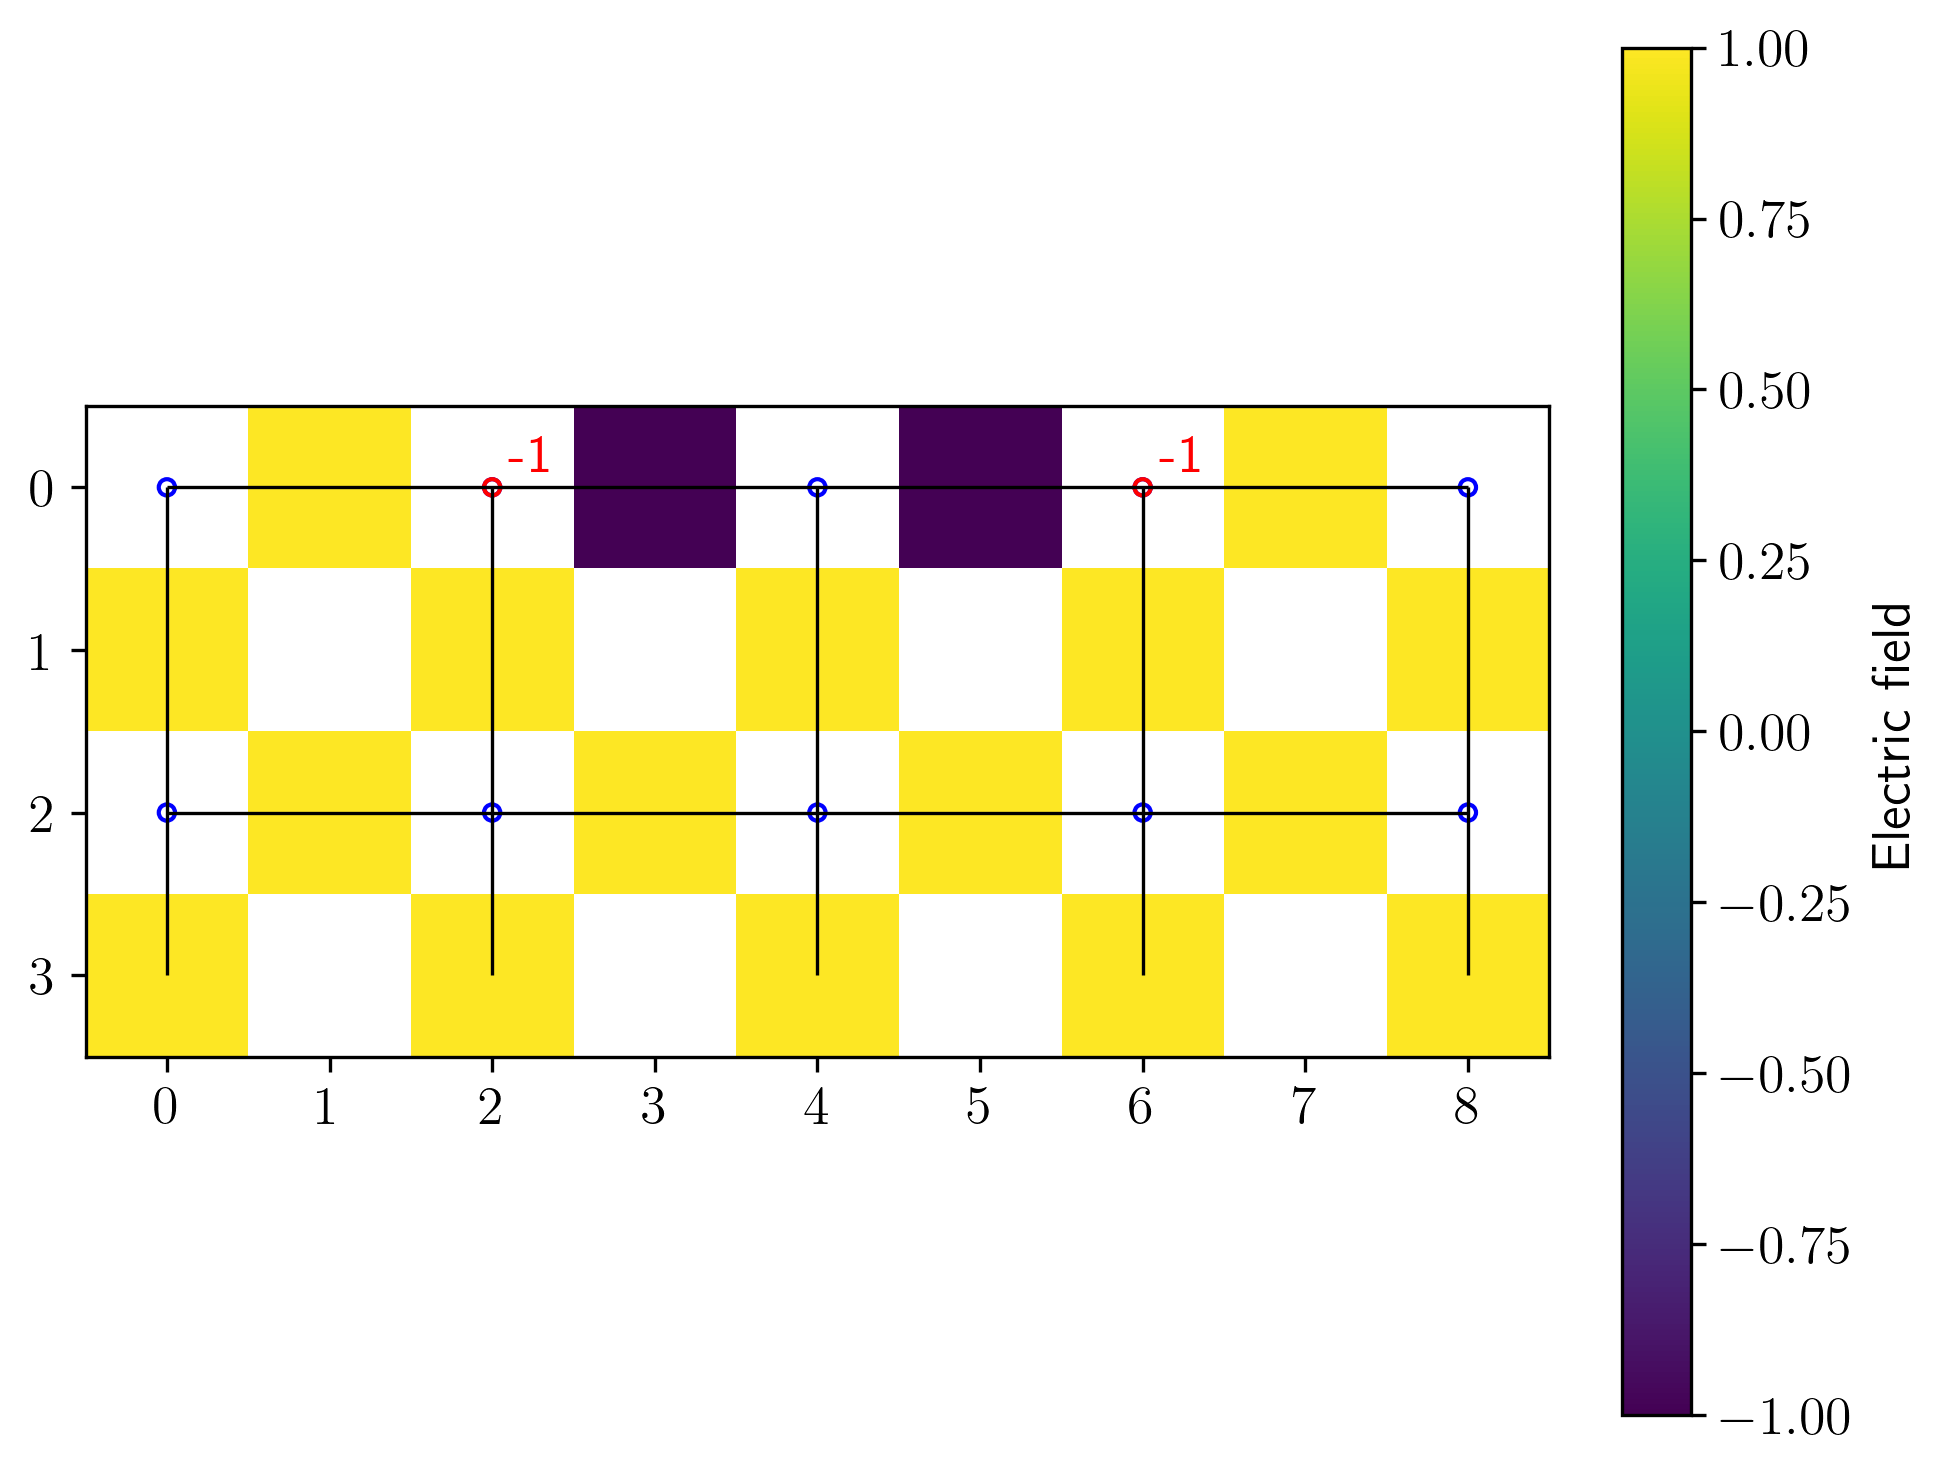

In [103]:
movie = anim(frames=steps+1, interval=200, data=e_field, params=np.linspace(0,steps*delta,steps+1), show=True, charges_x=cx, charges_y=cy, precision=2, time=True)
movie.save(filename="quench_exact_test_1.gif")

/Users/fradm98/opt/anaconda3/envs/tensor_env/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/fradm98/opt/anaconda3/envs/tensor_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


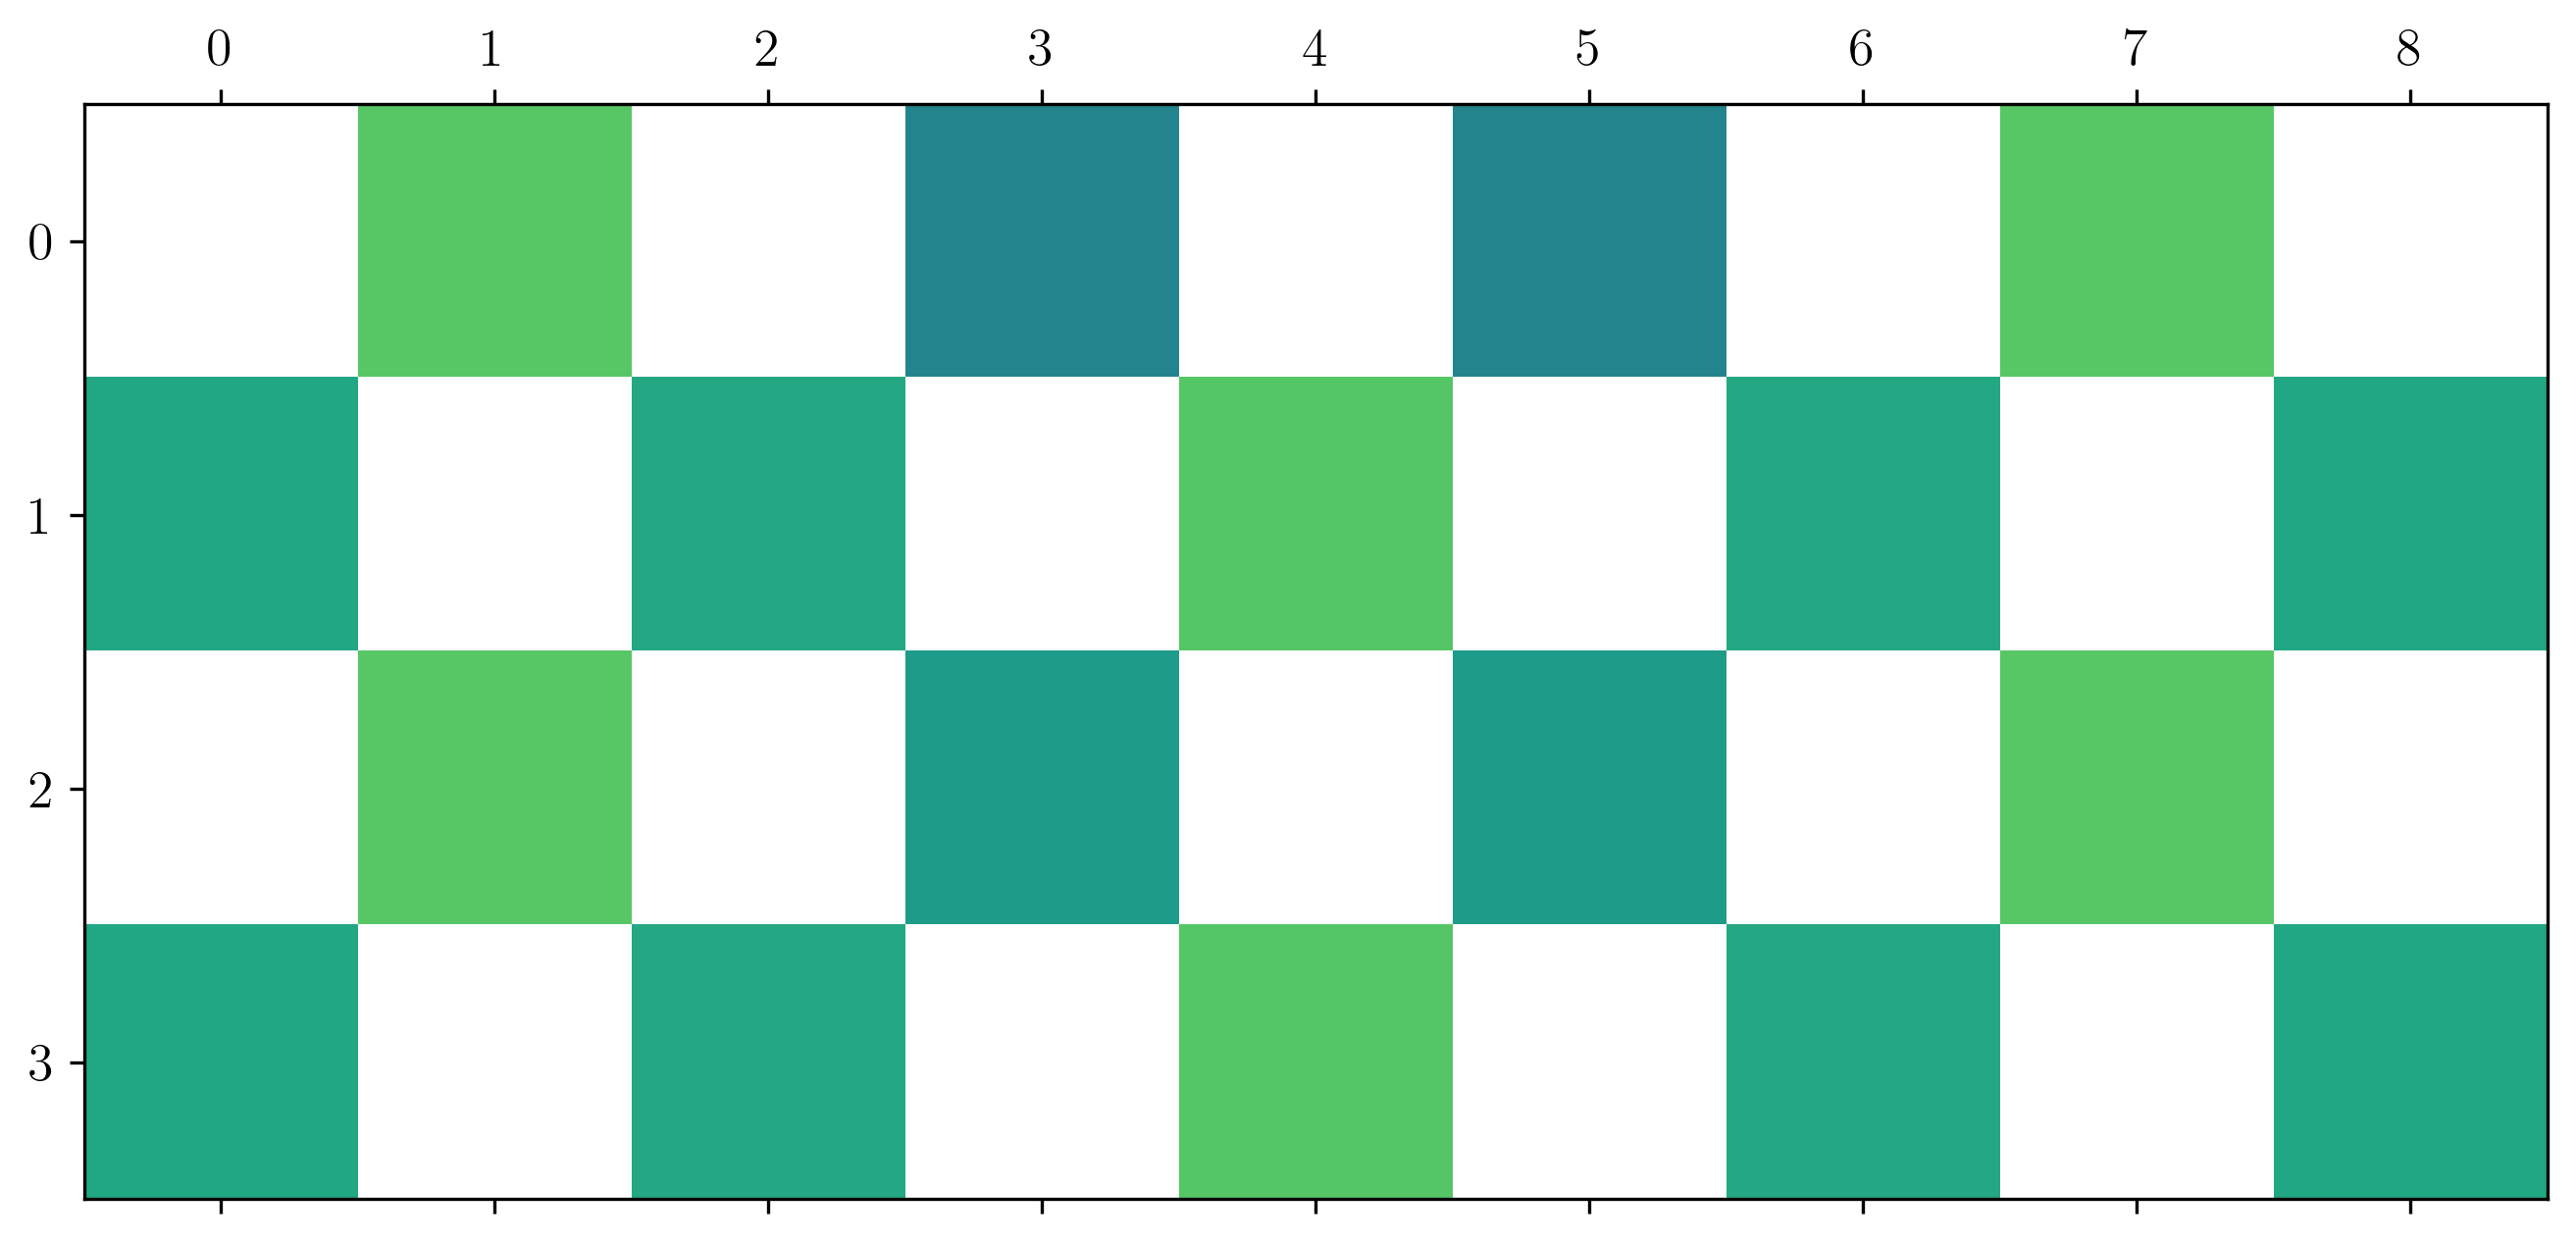

In [104]:
plt.matshow(e_field[-1], vmin=-1, vmax=1)

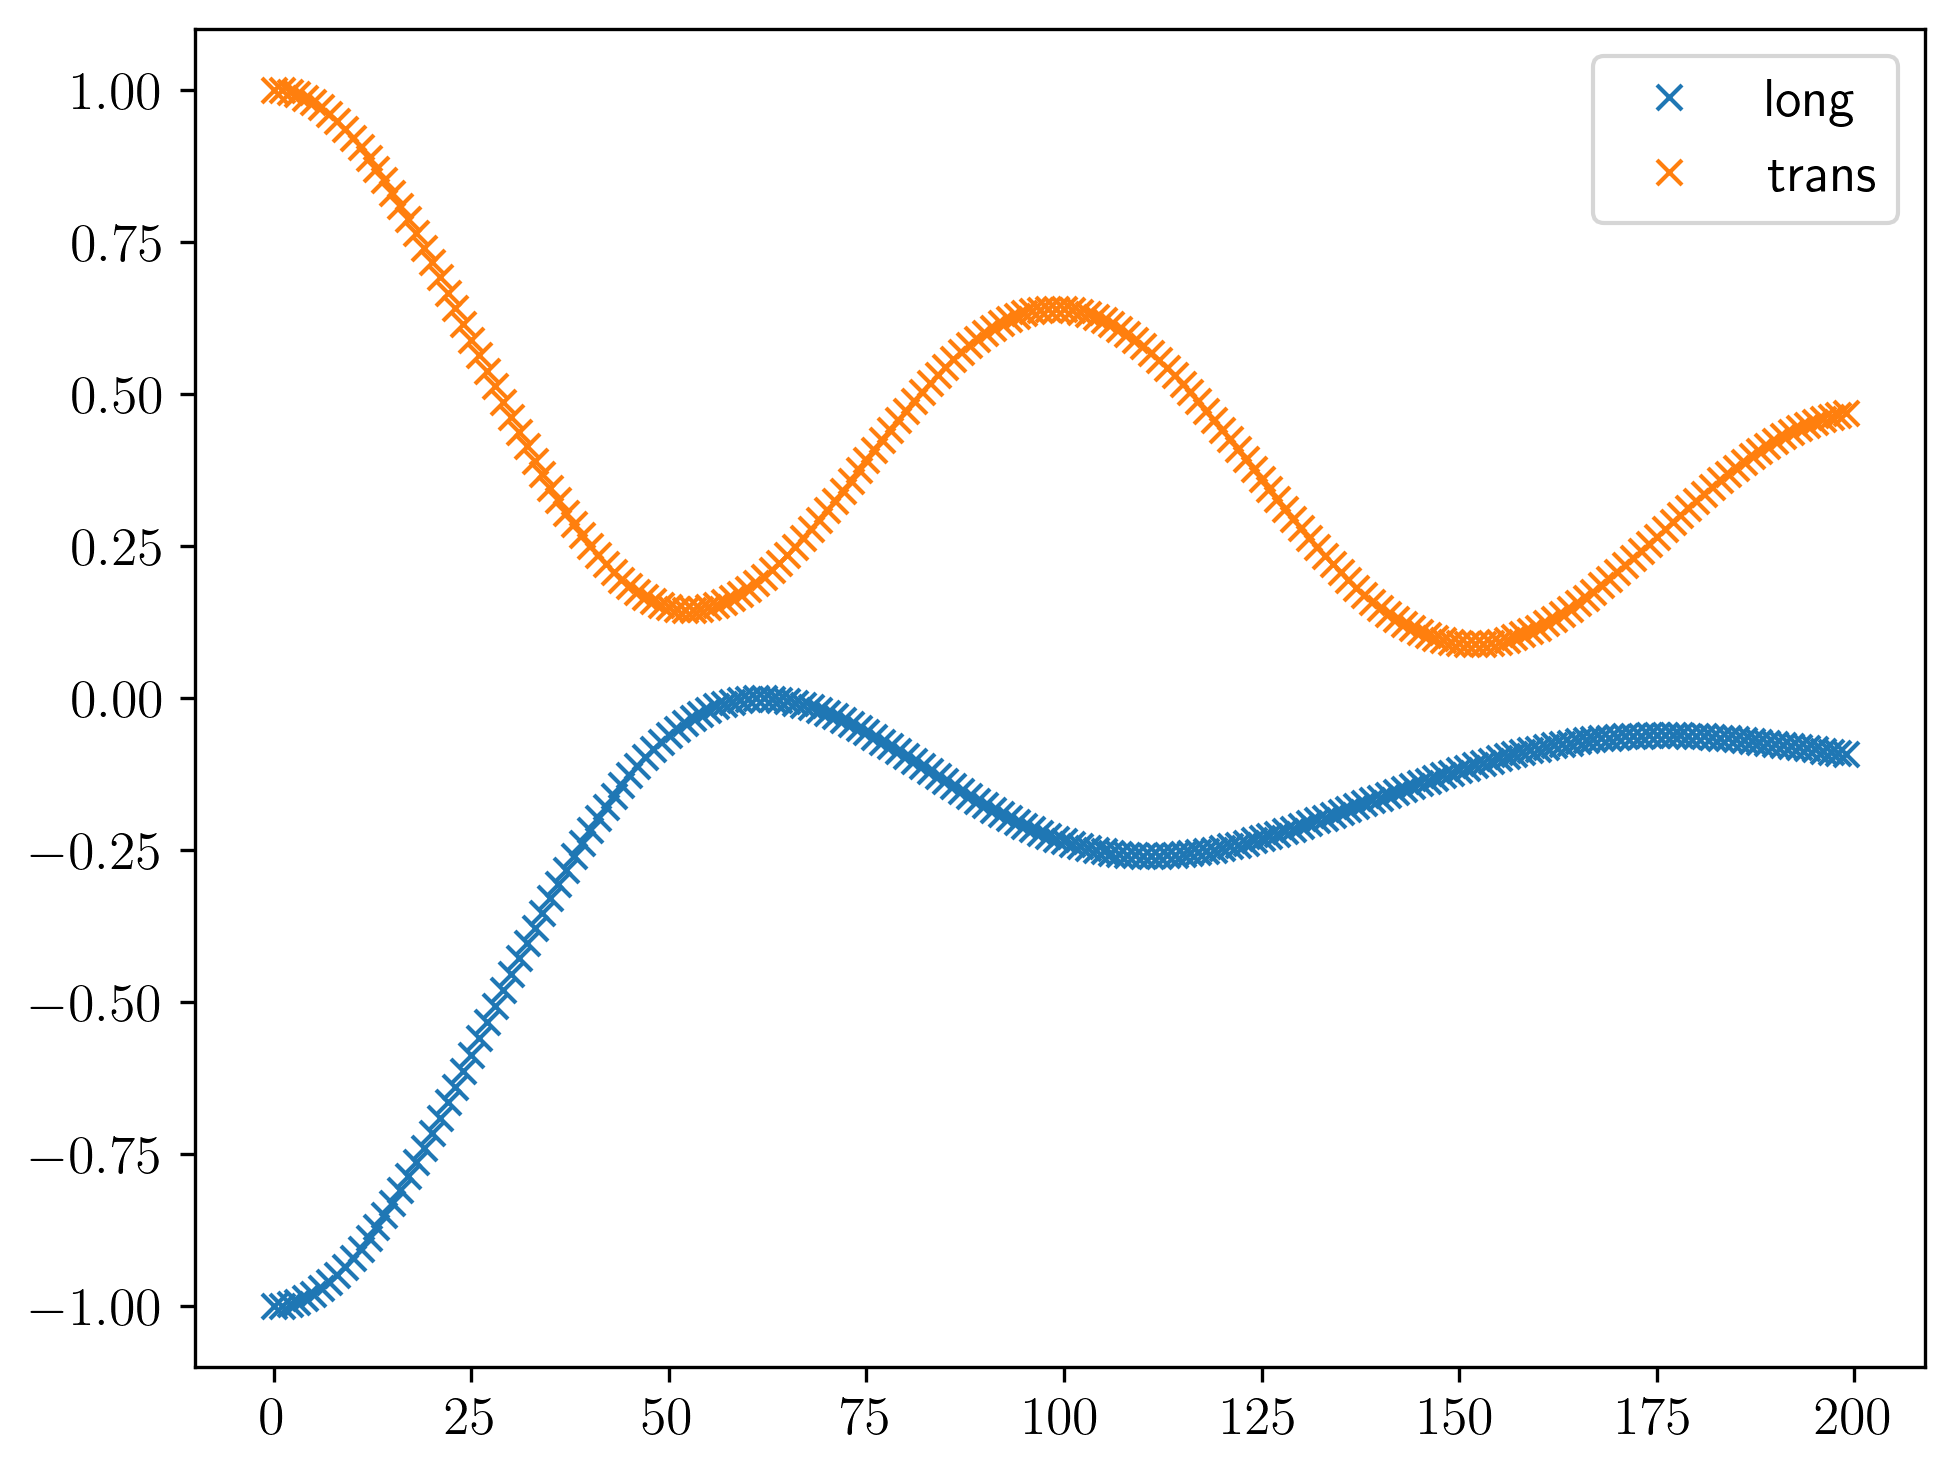

In [105]:
plt.plot([np.mean(e_field[i][0][1::2][cx[0]:cx[1]]) for i in range(steps)], 'x', label="long")
plt.plot([np.mean(e_field[i][1::2,0::2], axis=0)[(L+1)//2] for i in range(steps)], 'x', label="trans")
plt.legend()

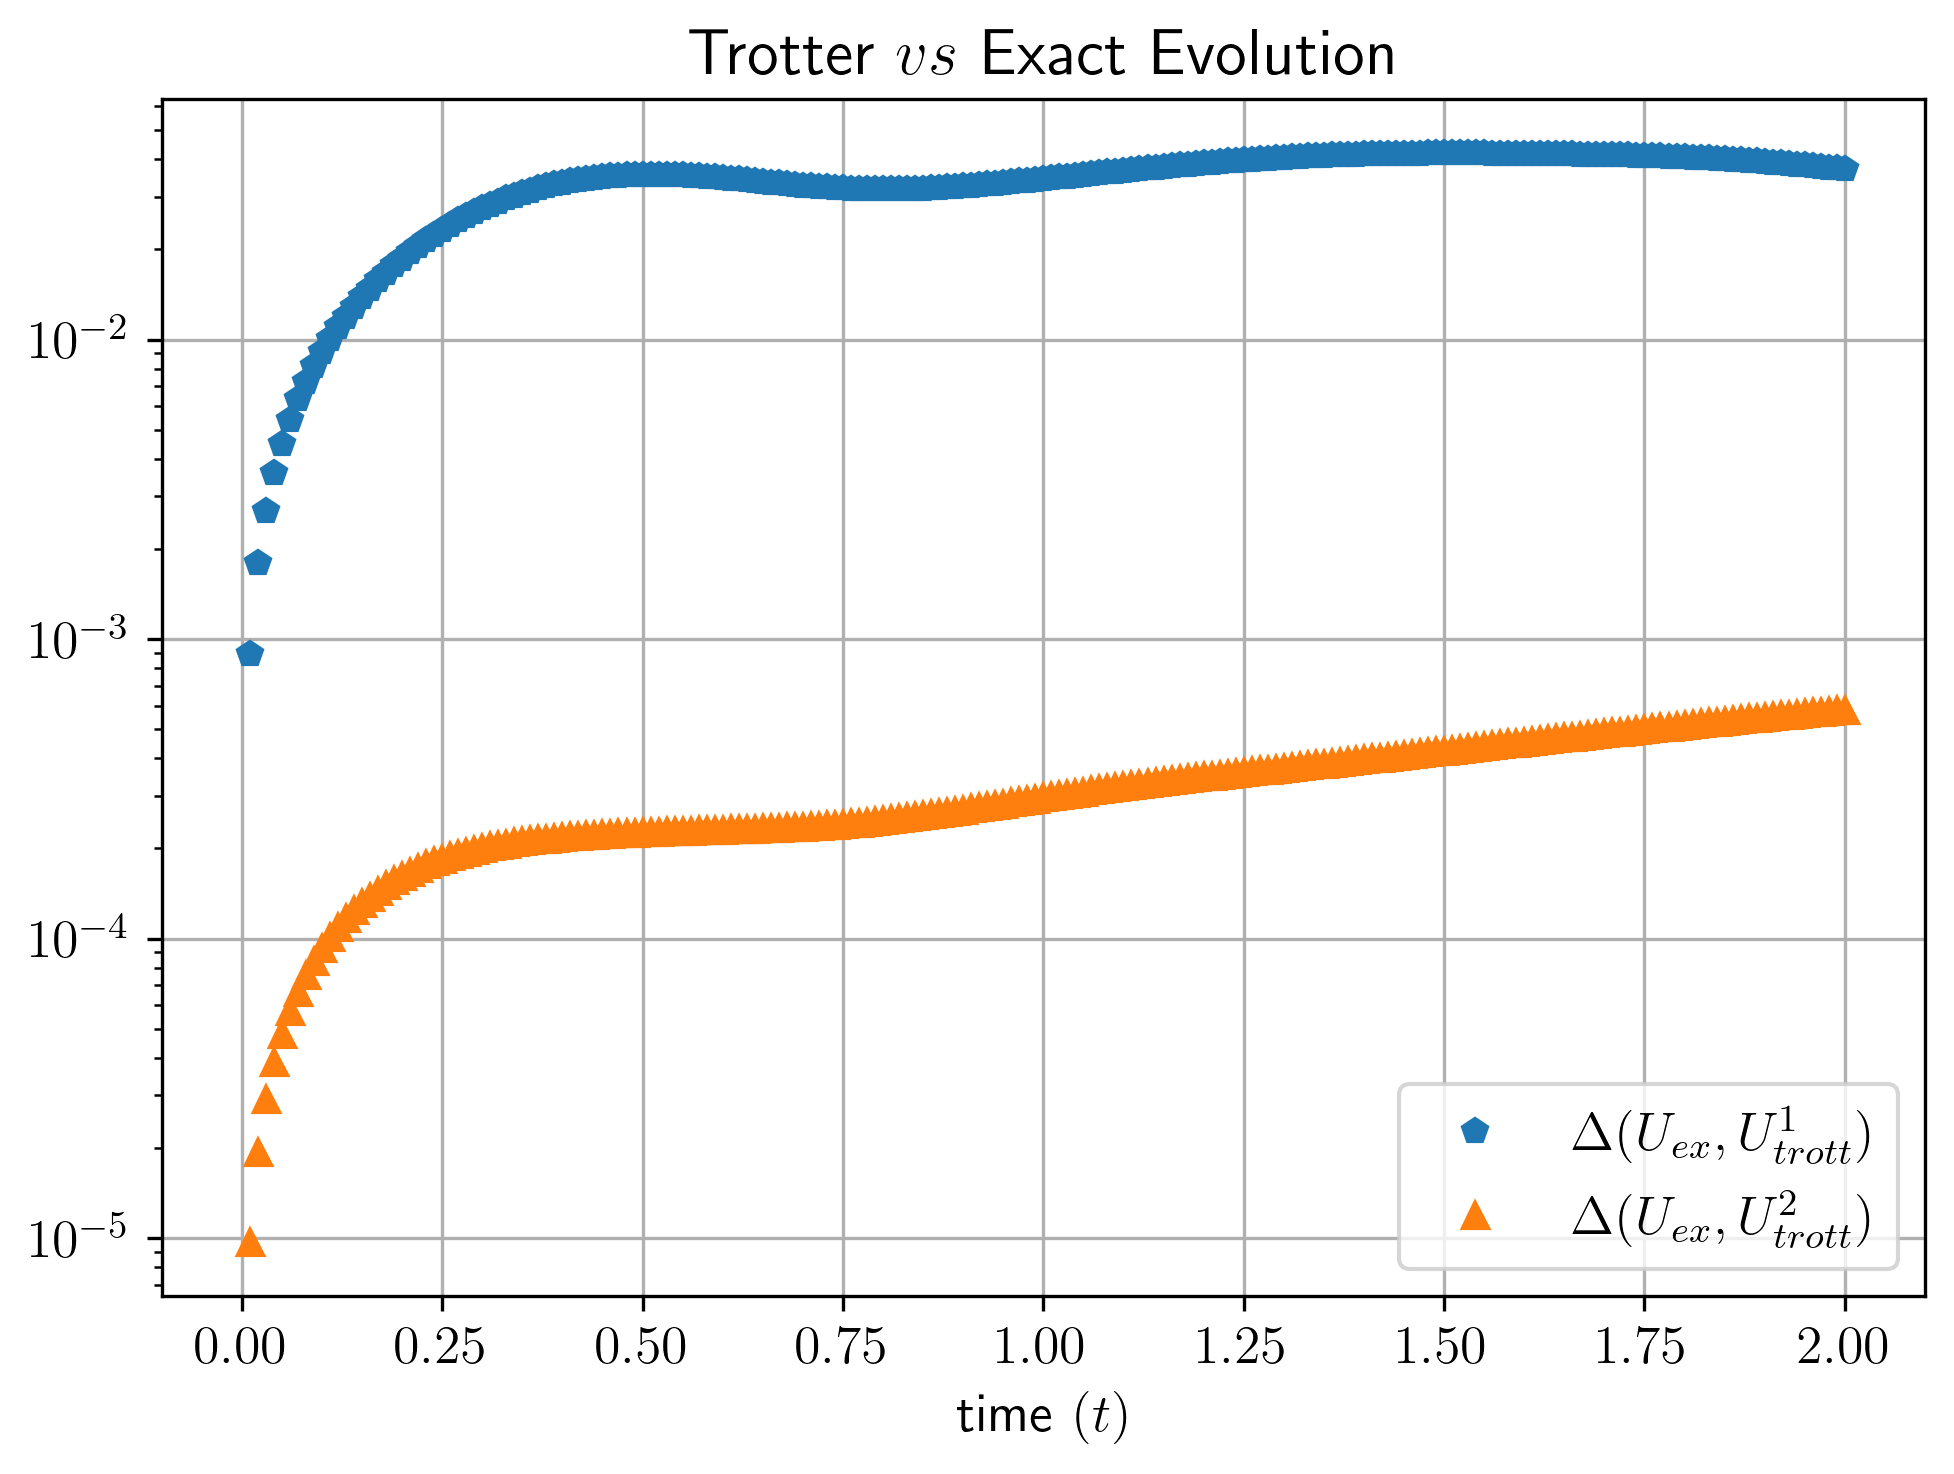

In [106]:
plt.plot(delta*np.asarray(range(steps+1)),diff1, marker="p", linestyle='', label="$\\Delta(U_{ex},U_{trott}^1)$")
plt.plot(delta*np.asarray(range(steps+1)),diff2, marker="^", linestyle='', label="$\\Delta (U_{ex},U_{trott}^2)$")
# plt.plot(range(1,steps),diff4, marker="+", label="$\\Delta (U_{ex},U_{trott}^4)$")
plt.title("Trotter $vs$ Exact Evolution")
plt.xlabel("time $(t)$")
# plt.xticks(ticks=delta*range(1,steps)[::(steps-1)//5], ticks=delta*range(1,steps)[::(steps-1)//5])
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

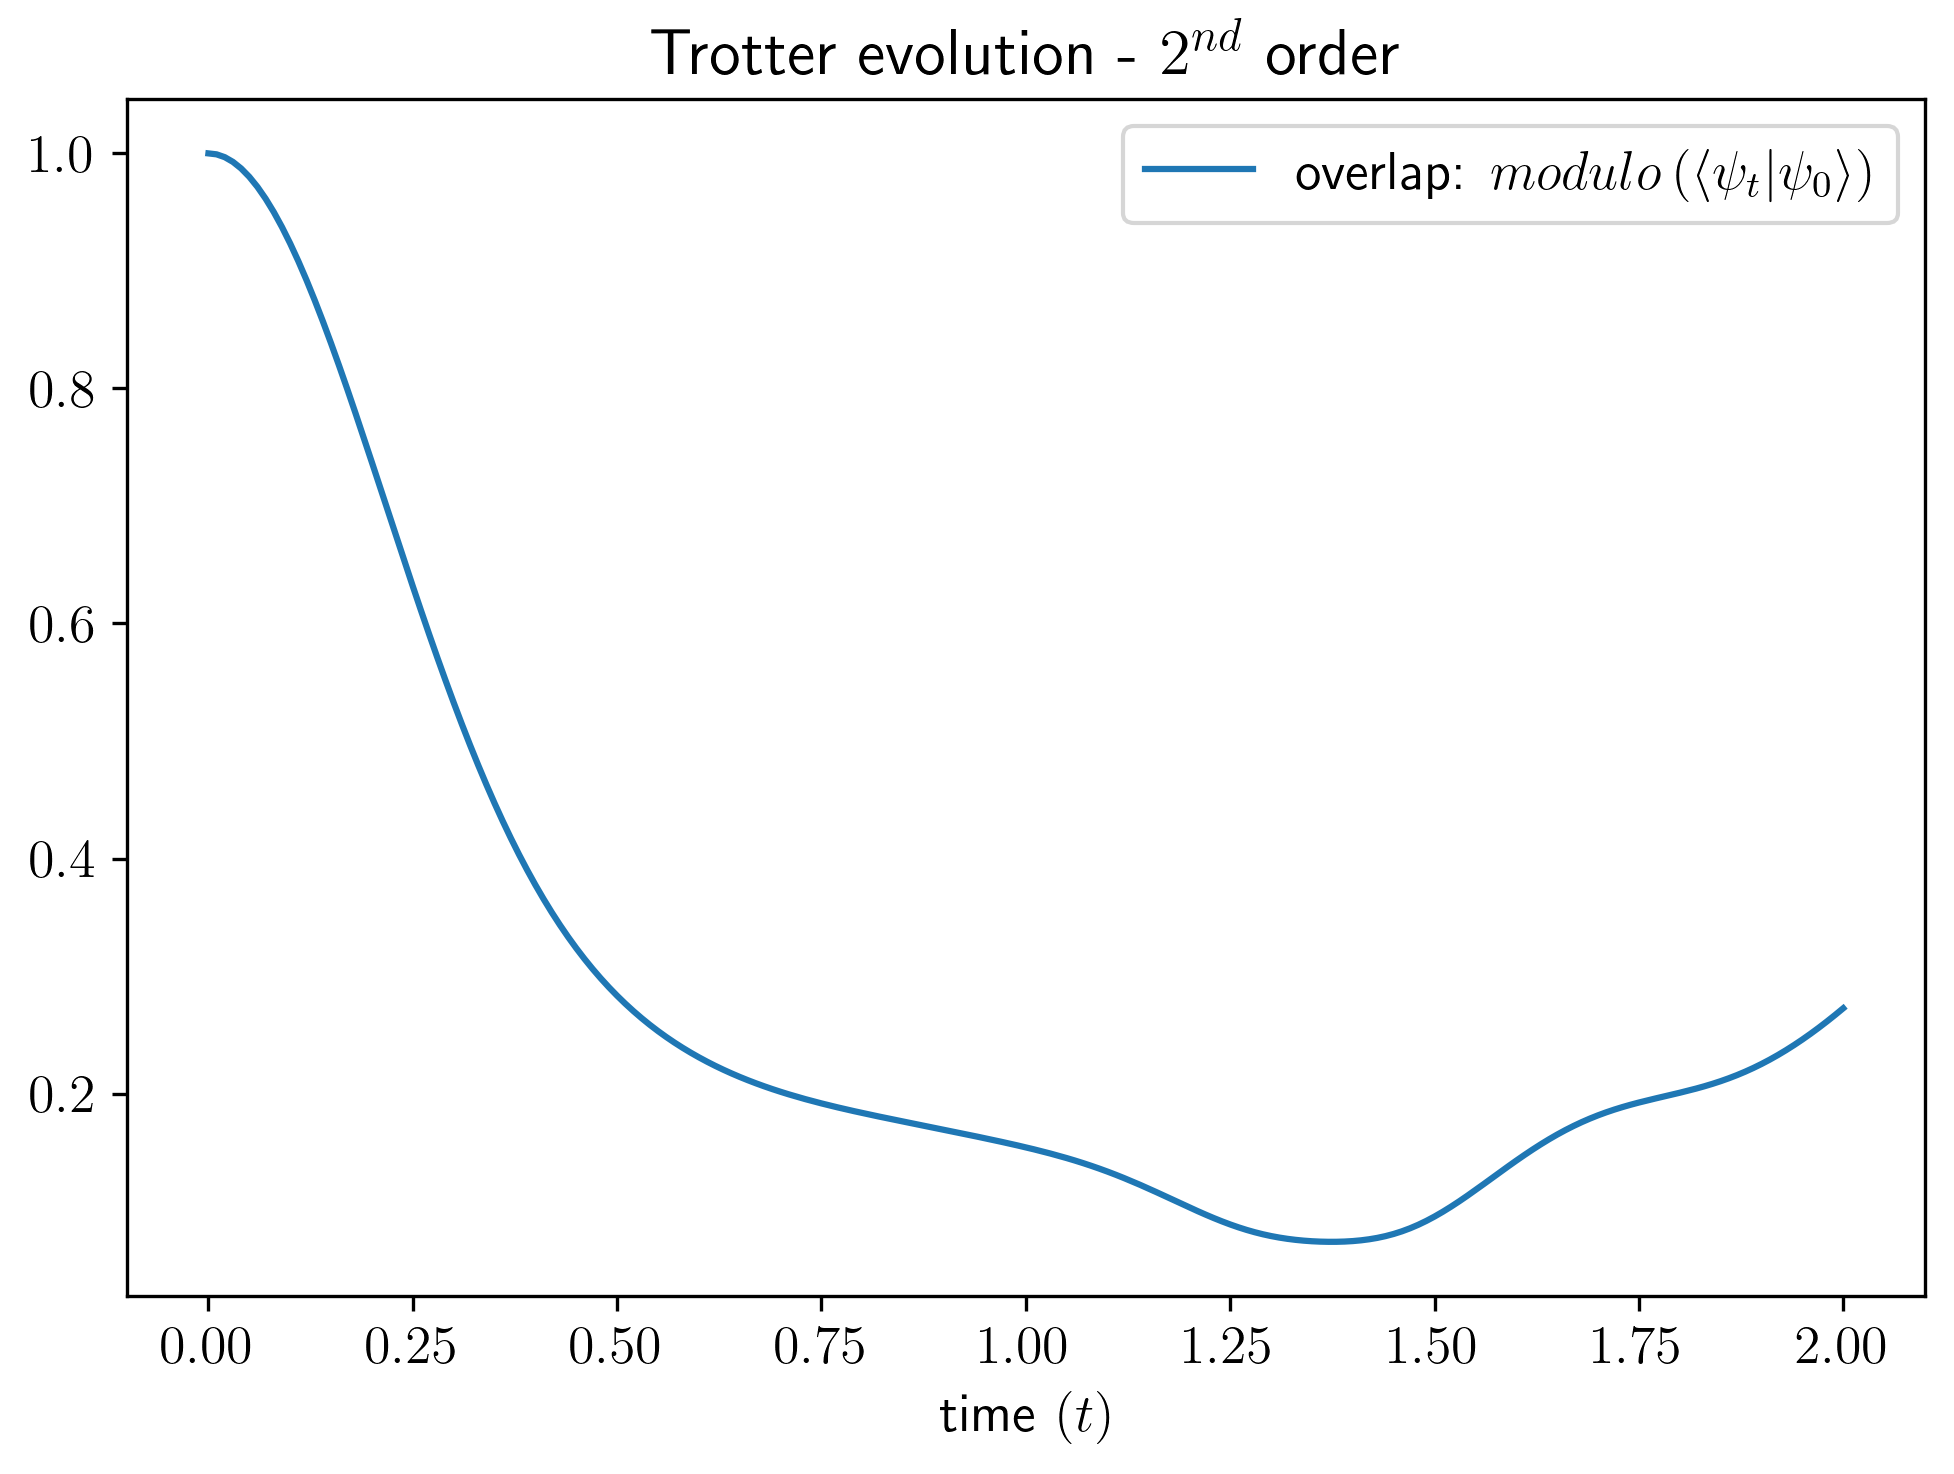

In [107]:
plt.plot(delta*np.asarray(range(steps+1)),[np.sqrt(ov.real**2 + ov.imag**2) for ov in overlap], label="overlap: $modulo \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

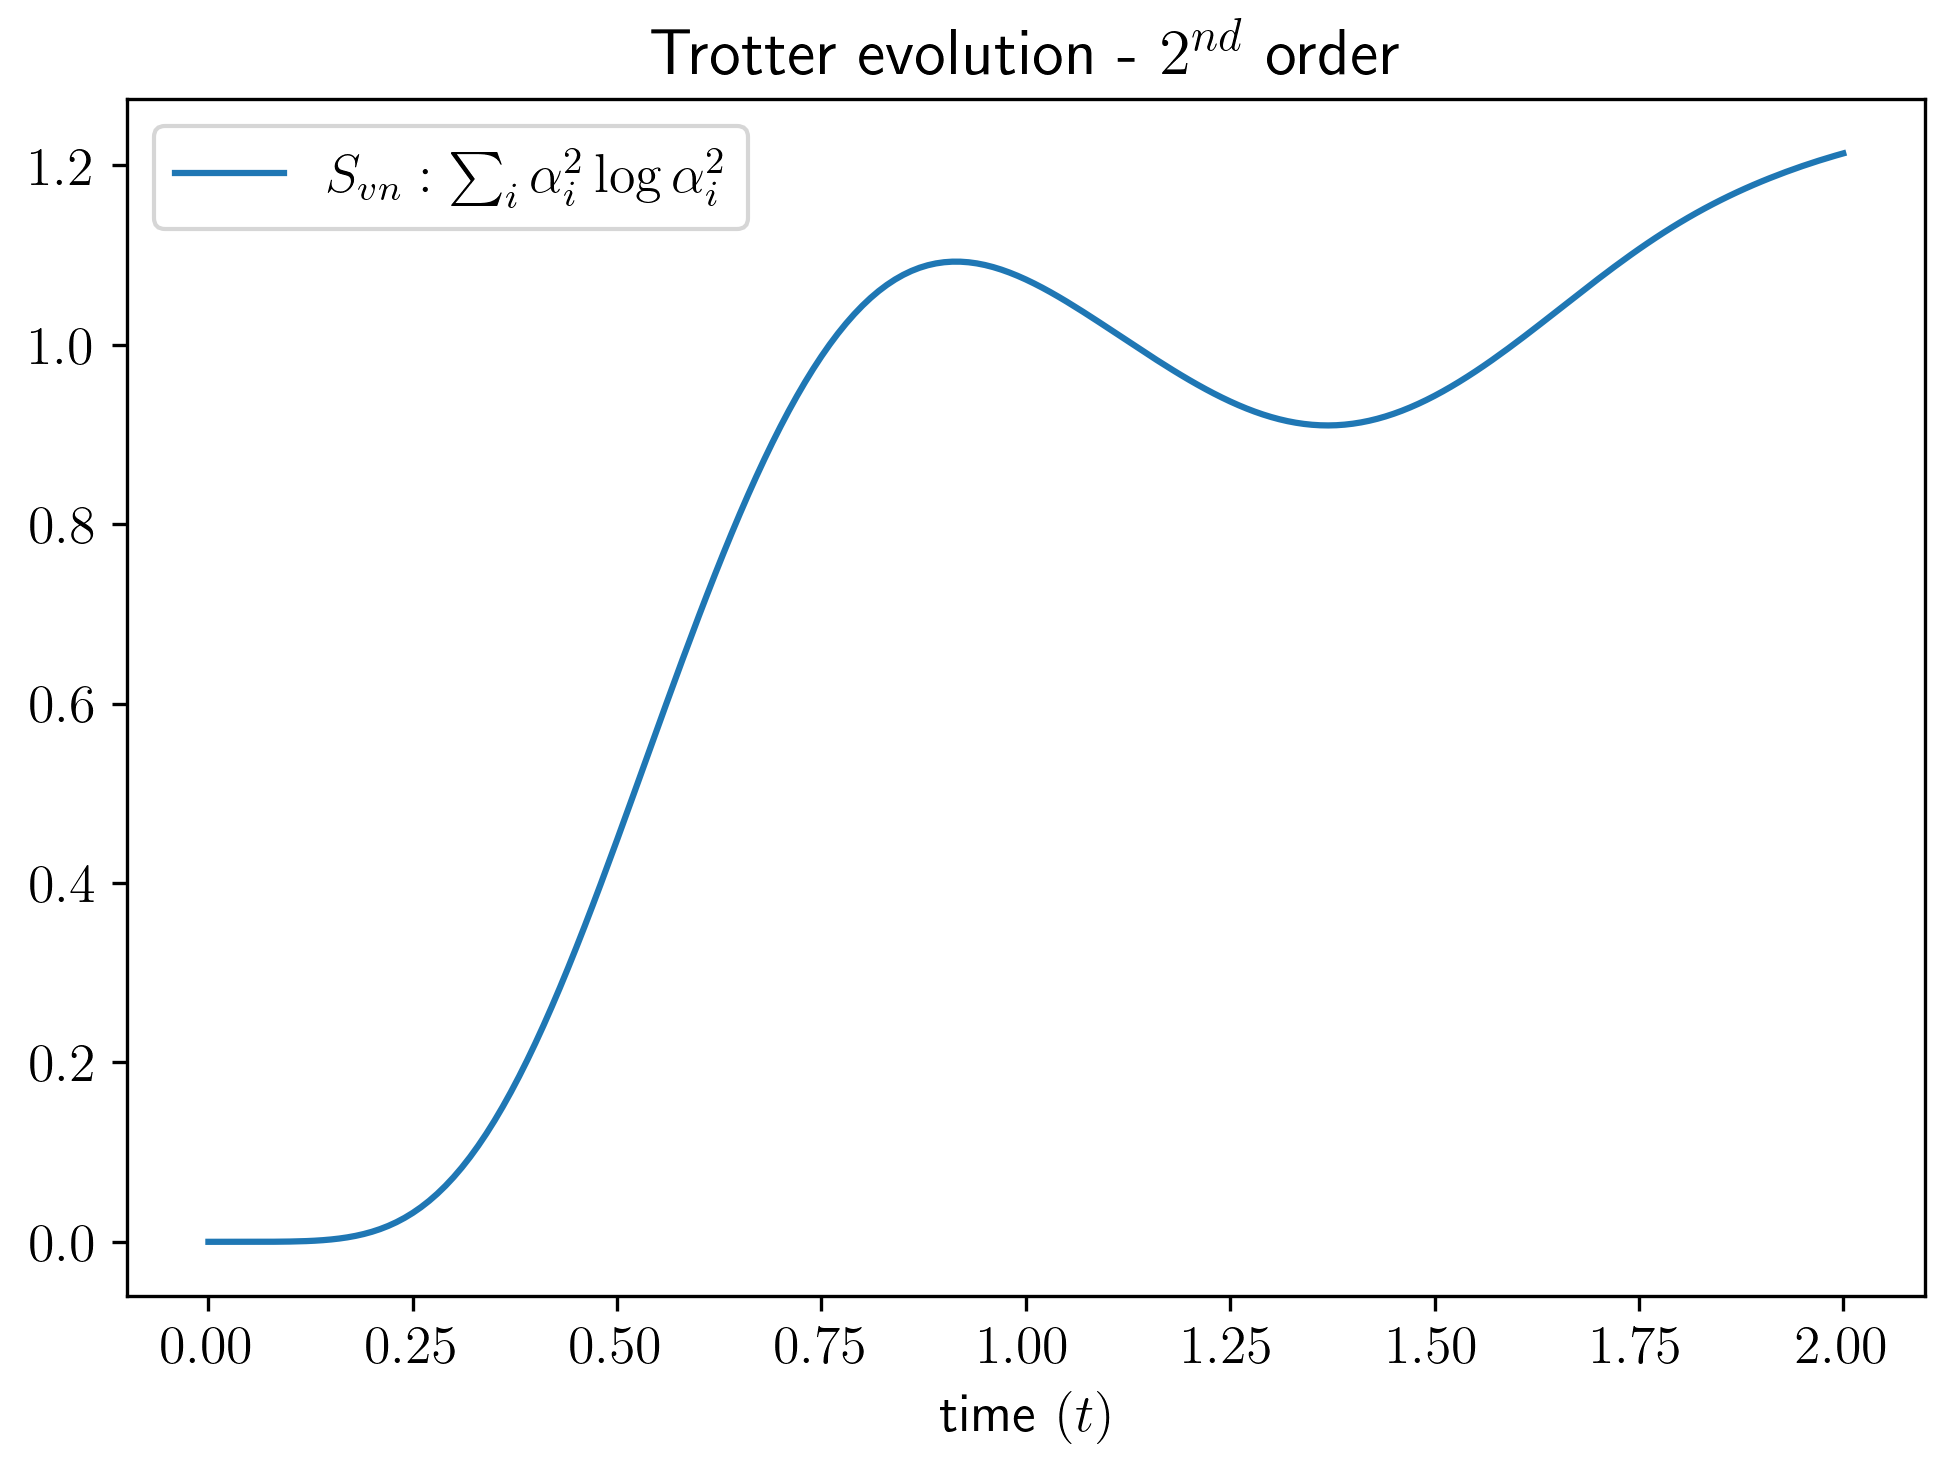

In [108]:
plt.plot(delta*np.asarray(range(steps+1)), entropy, label="$S_{vn}: \\sum_i \\alpha_i^2 \\log{\\alpha_i^2}$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

## 2. Build evolution MPO for PBC

### 2.1 initialize the system in a ground state

In [172]:
l = 2
L = 4
g = 10
R = 2
bc = "pbc"
cx = get_cx(L=L,R=R)
cy = get_cy(l=L, bc=bc)
chi = 32
mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=g, bc=bc)
mps._random_state(seed=3,type_shape="rectangular",chi=chi)
mps.canonical_form()
mps.Z2.add_charges(cx,cy)
mps.charges = mps.Z2.charges
mps.Z2._define_sector()
a = np.zeros((1,2))
a[0,0] = 1
extra_ancillary_site = a.reshape((1,2,1))
mps.sites.append(extra_ancillary_site)
mps.L = len(mps.sites)
mps.DMRG(trunc_chi=True, trunc_tol=False, where=L//2)
mps.sites.pop()
mps.L = len(mps.sites)

Sweep n: 0

Sweep n: 1



### 2.2 Apply the trotter evolution MPO on the MPS

In [173]:
# we created the function in the MPS class
steps = 100
delta = 0.01
g_ev = 0.7
(errors, entropies, e_field, overlap, trott_err) = mps.TEBD_variational_Z2(trotter_steps=steps, delta=delta, h_ev=g_ev, where=L//2, exact=True, cx=cx,cy=cy)

overlap between initial state dmrg and initial state exact:
(-0.32355701885385724-0.9462053716248034j)
------ Trotter steps: 0 -------
Bond dim ancilla: 32
Bond dim site: 32
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-07 after:
1 sweeps at site 4
total iterations 9
##############################
Bond dim ancilla: 32
Bond dim site: 16
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-07 after:
1 sweeps at site 4
total iterations 9
##############################
Evolution at time: 0.01
overlap between initial state dmrg and initial state exact:
------ Trotter steps: 1 -------
Bond dim ancilla: 16
Bond dim site: 16
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-07 after:
1 sweeps at site 4
total iterations 9
##############################
Bond dim

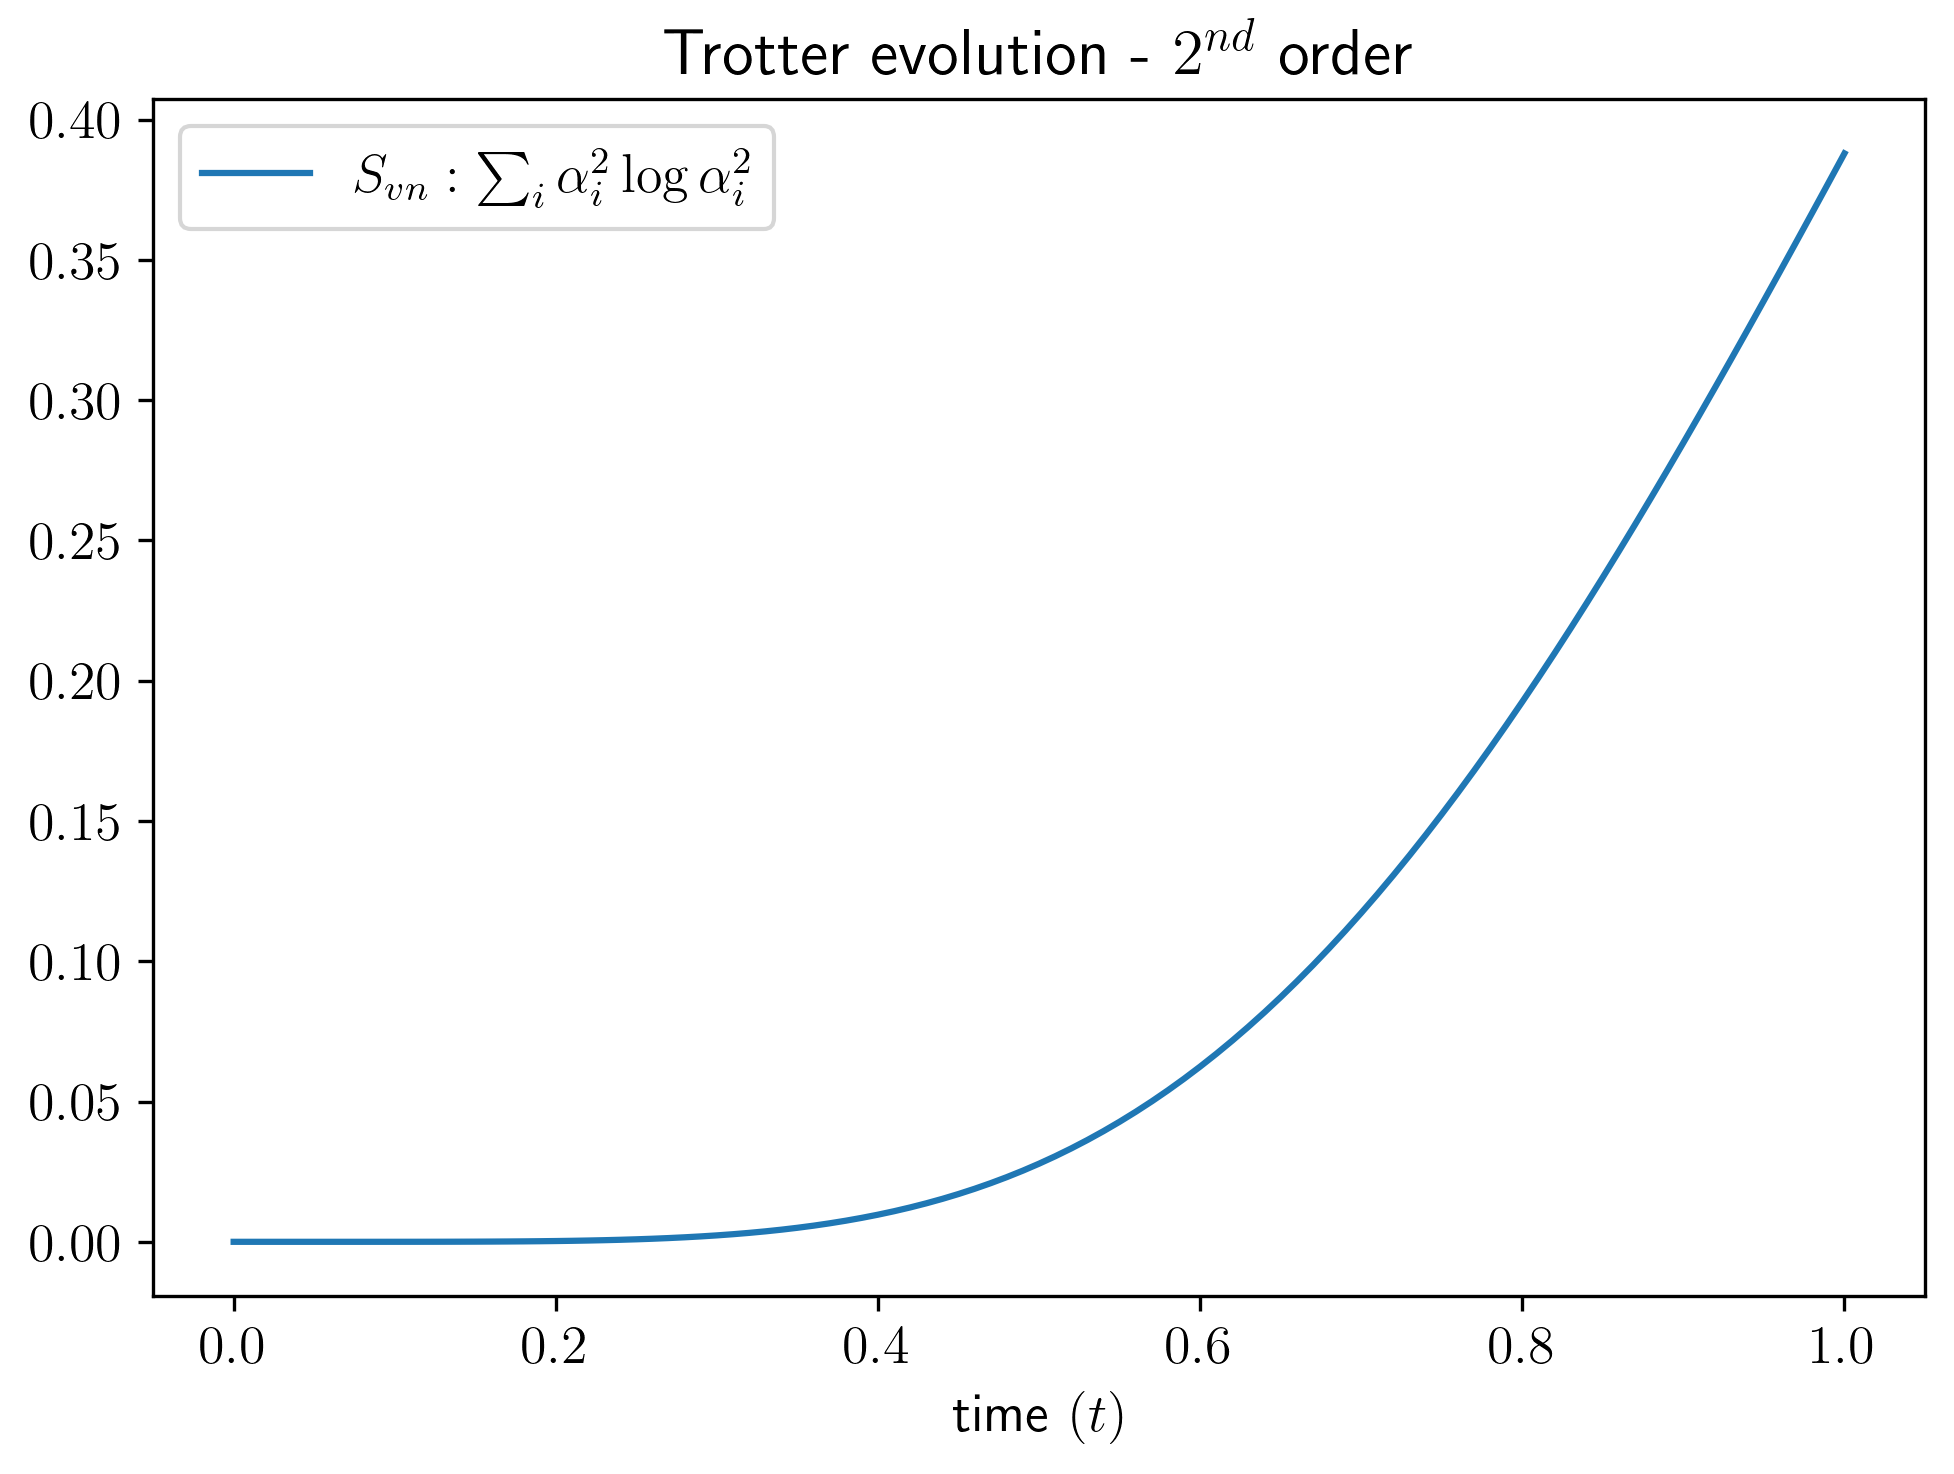

In [174]:
plt.plot(delta*np.asarray(range(steps+1)), entropies, label="$S_{vn}: \\sum_i \\alpha_i^2 \\log{\\alpha_i^2}$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

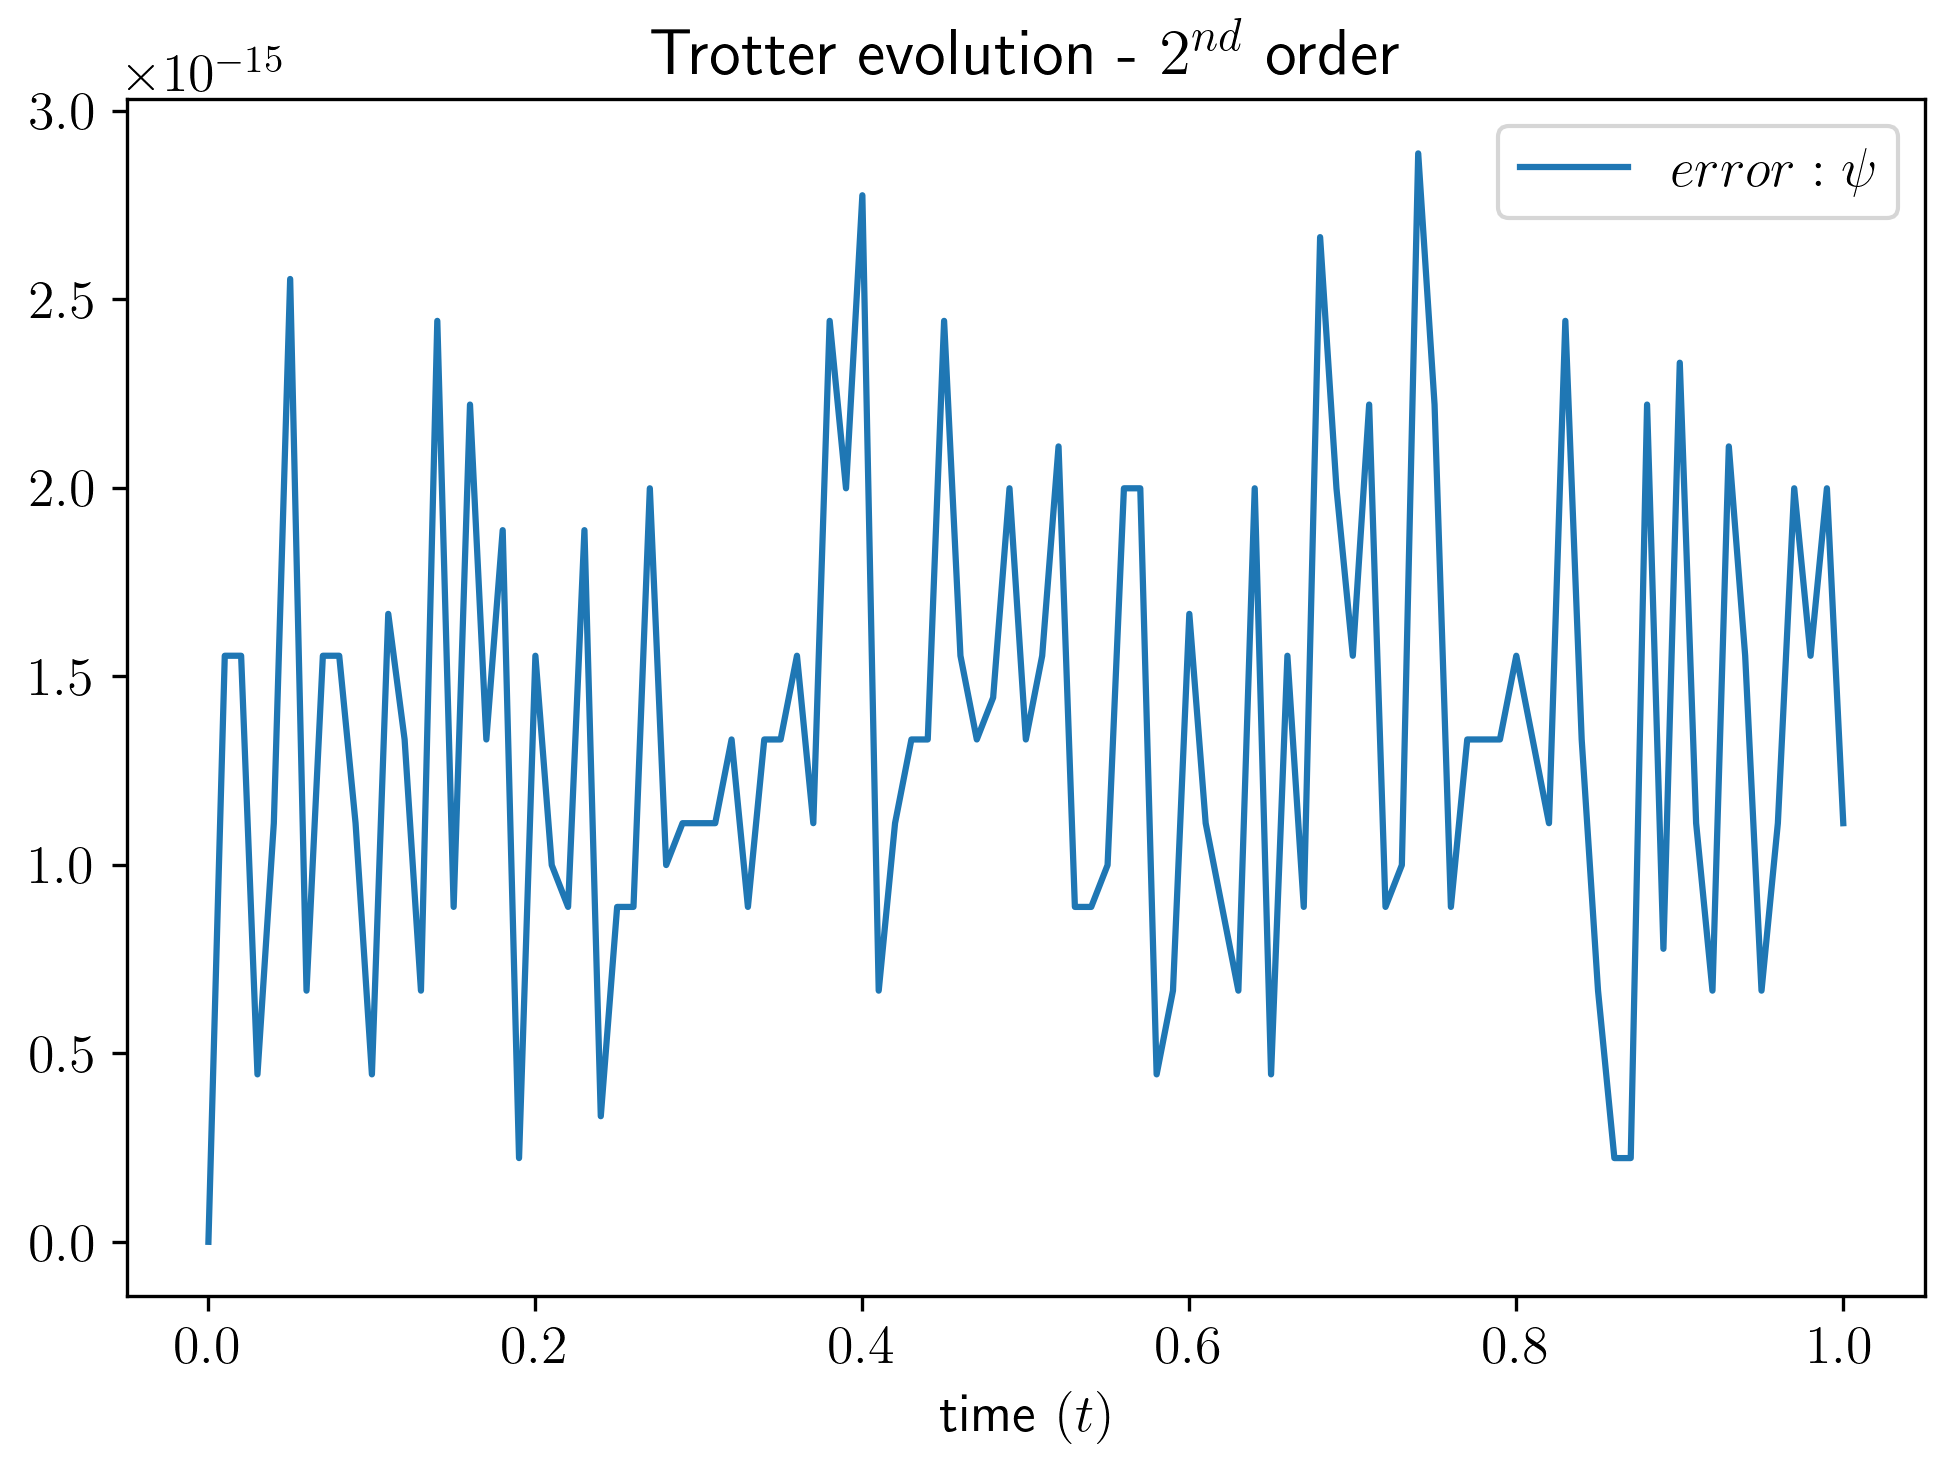

In [175]:
plt.plot(delta*np.asarray(range(steps+1)), np.asarray(errors)[:,-1], label="$error: \psi$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

/Users/fradm98/opt/anaconda3/envs/tensor_env/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/fradm98/opt/anaconda3/envs/tensor_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


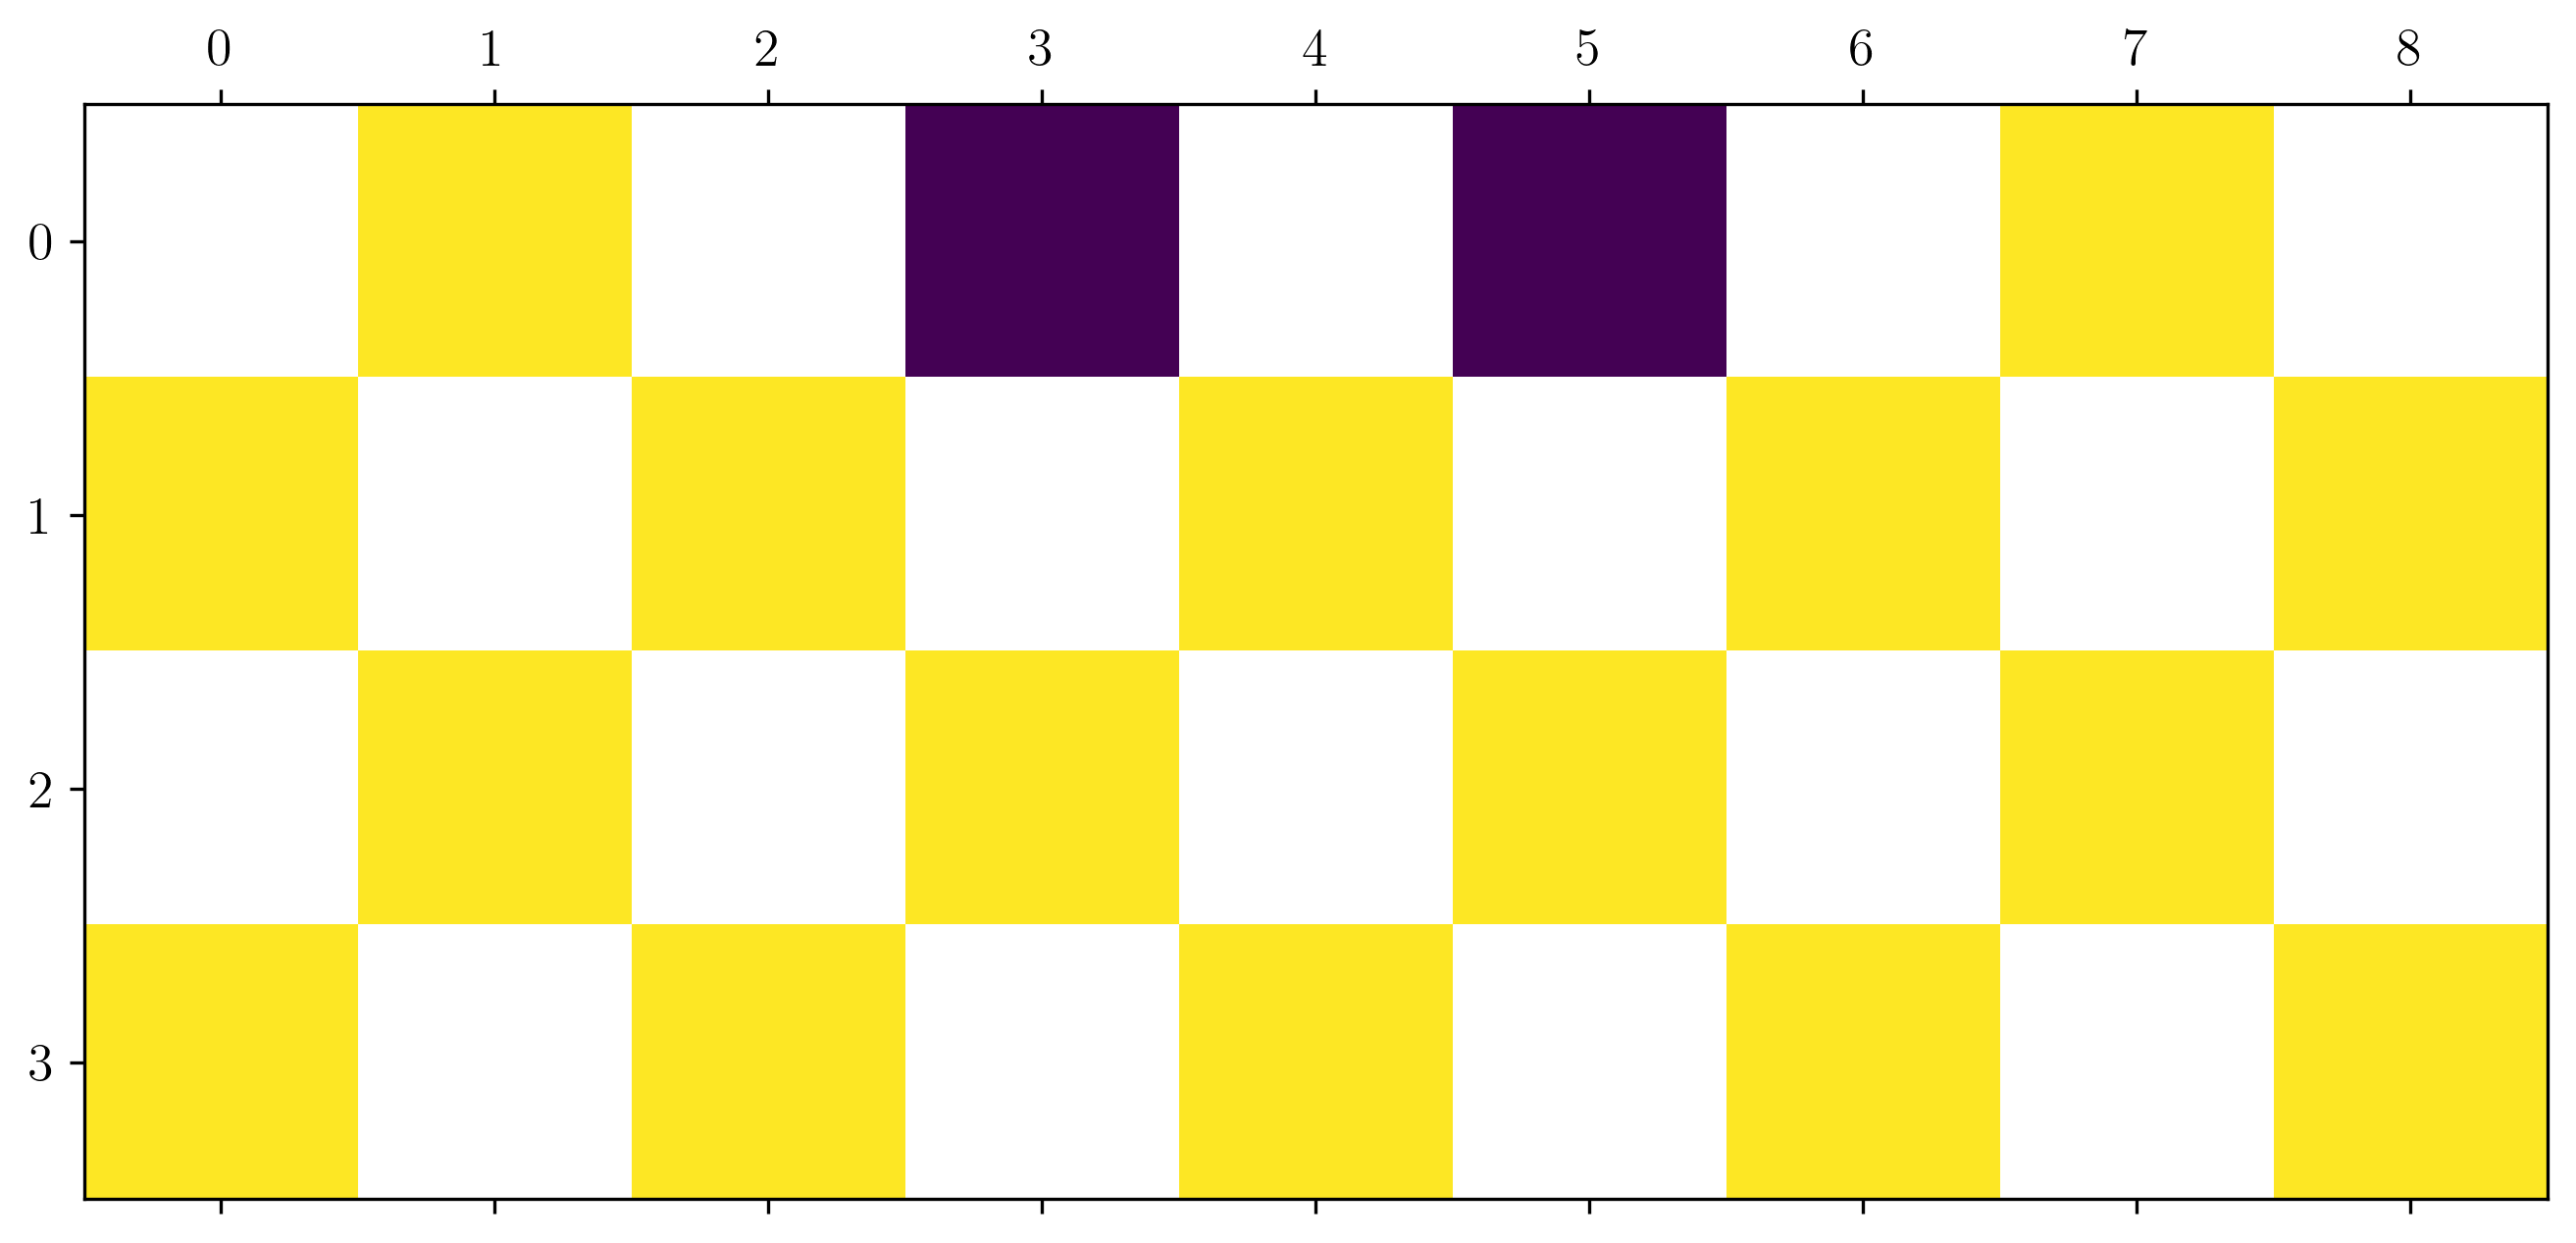

In [176]:
plt.matshow(e_field[0])

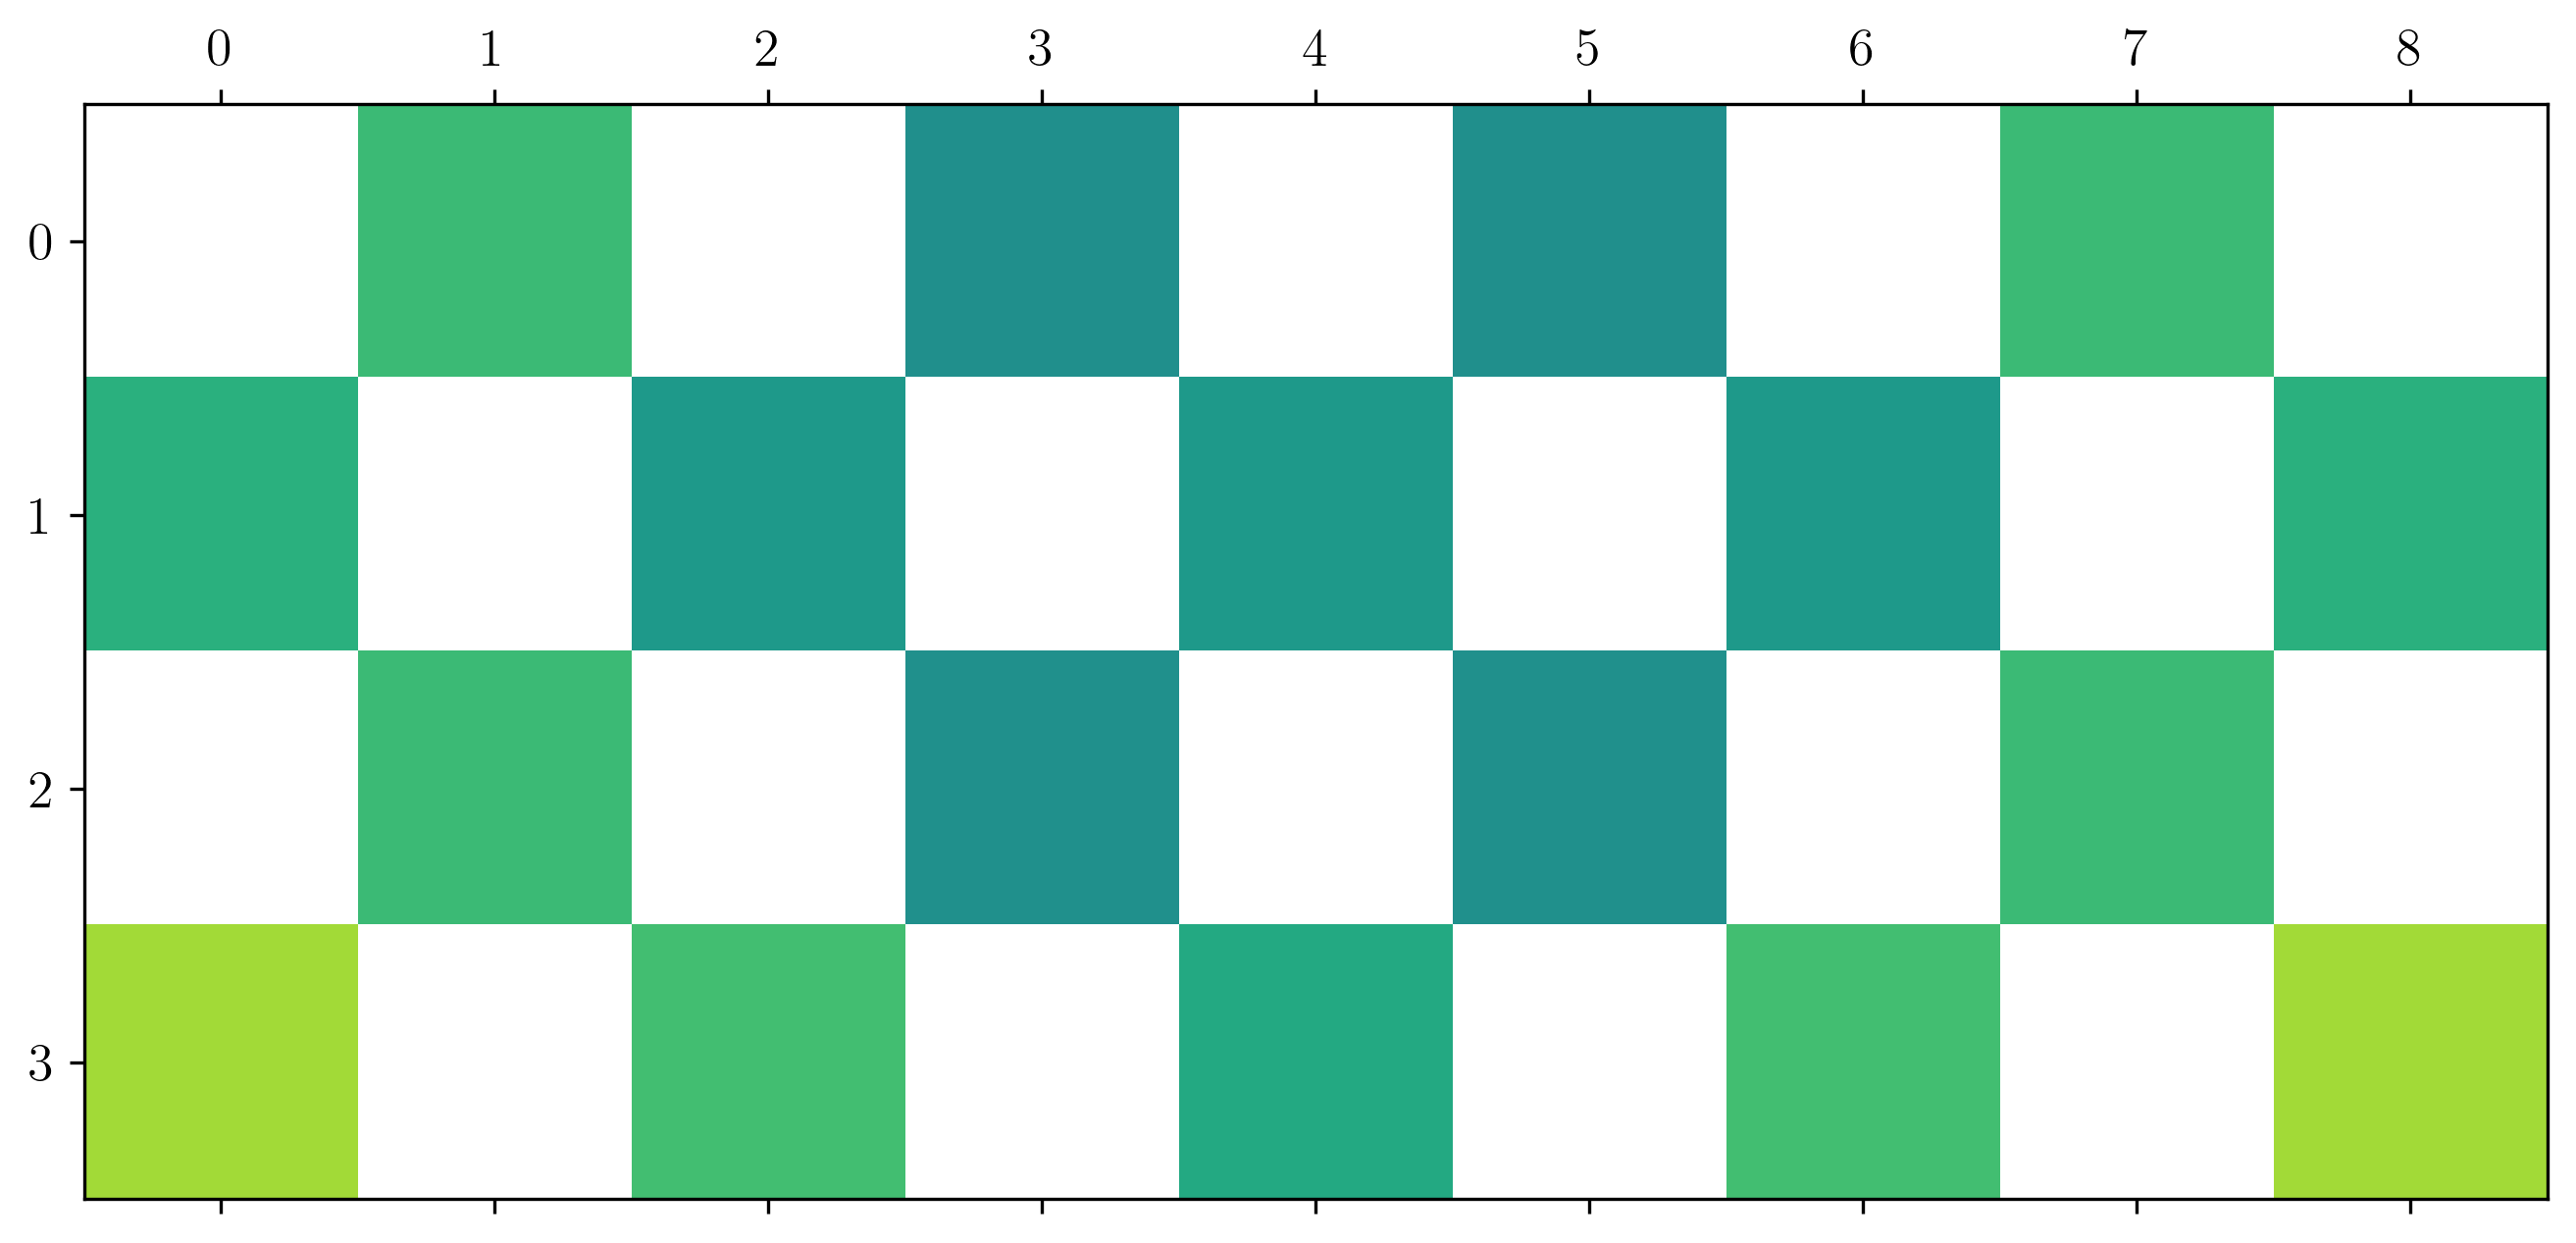

In [177]:
plt.matshow(e_field[-1], vmin=-1, vmax=1)

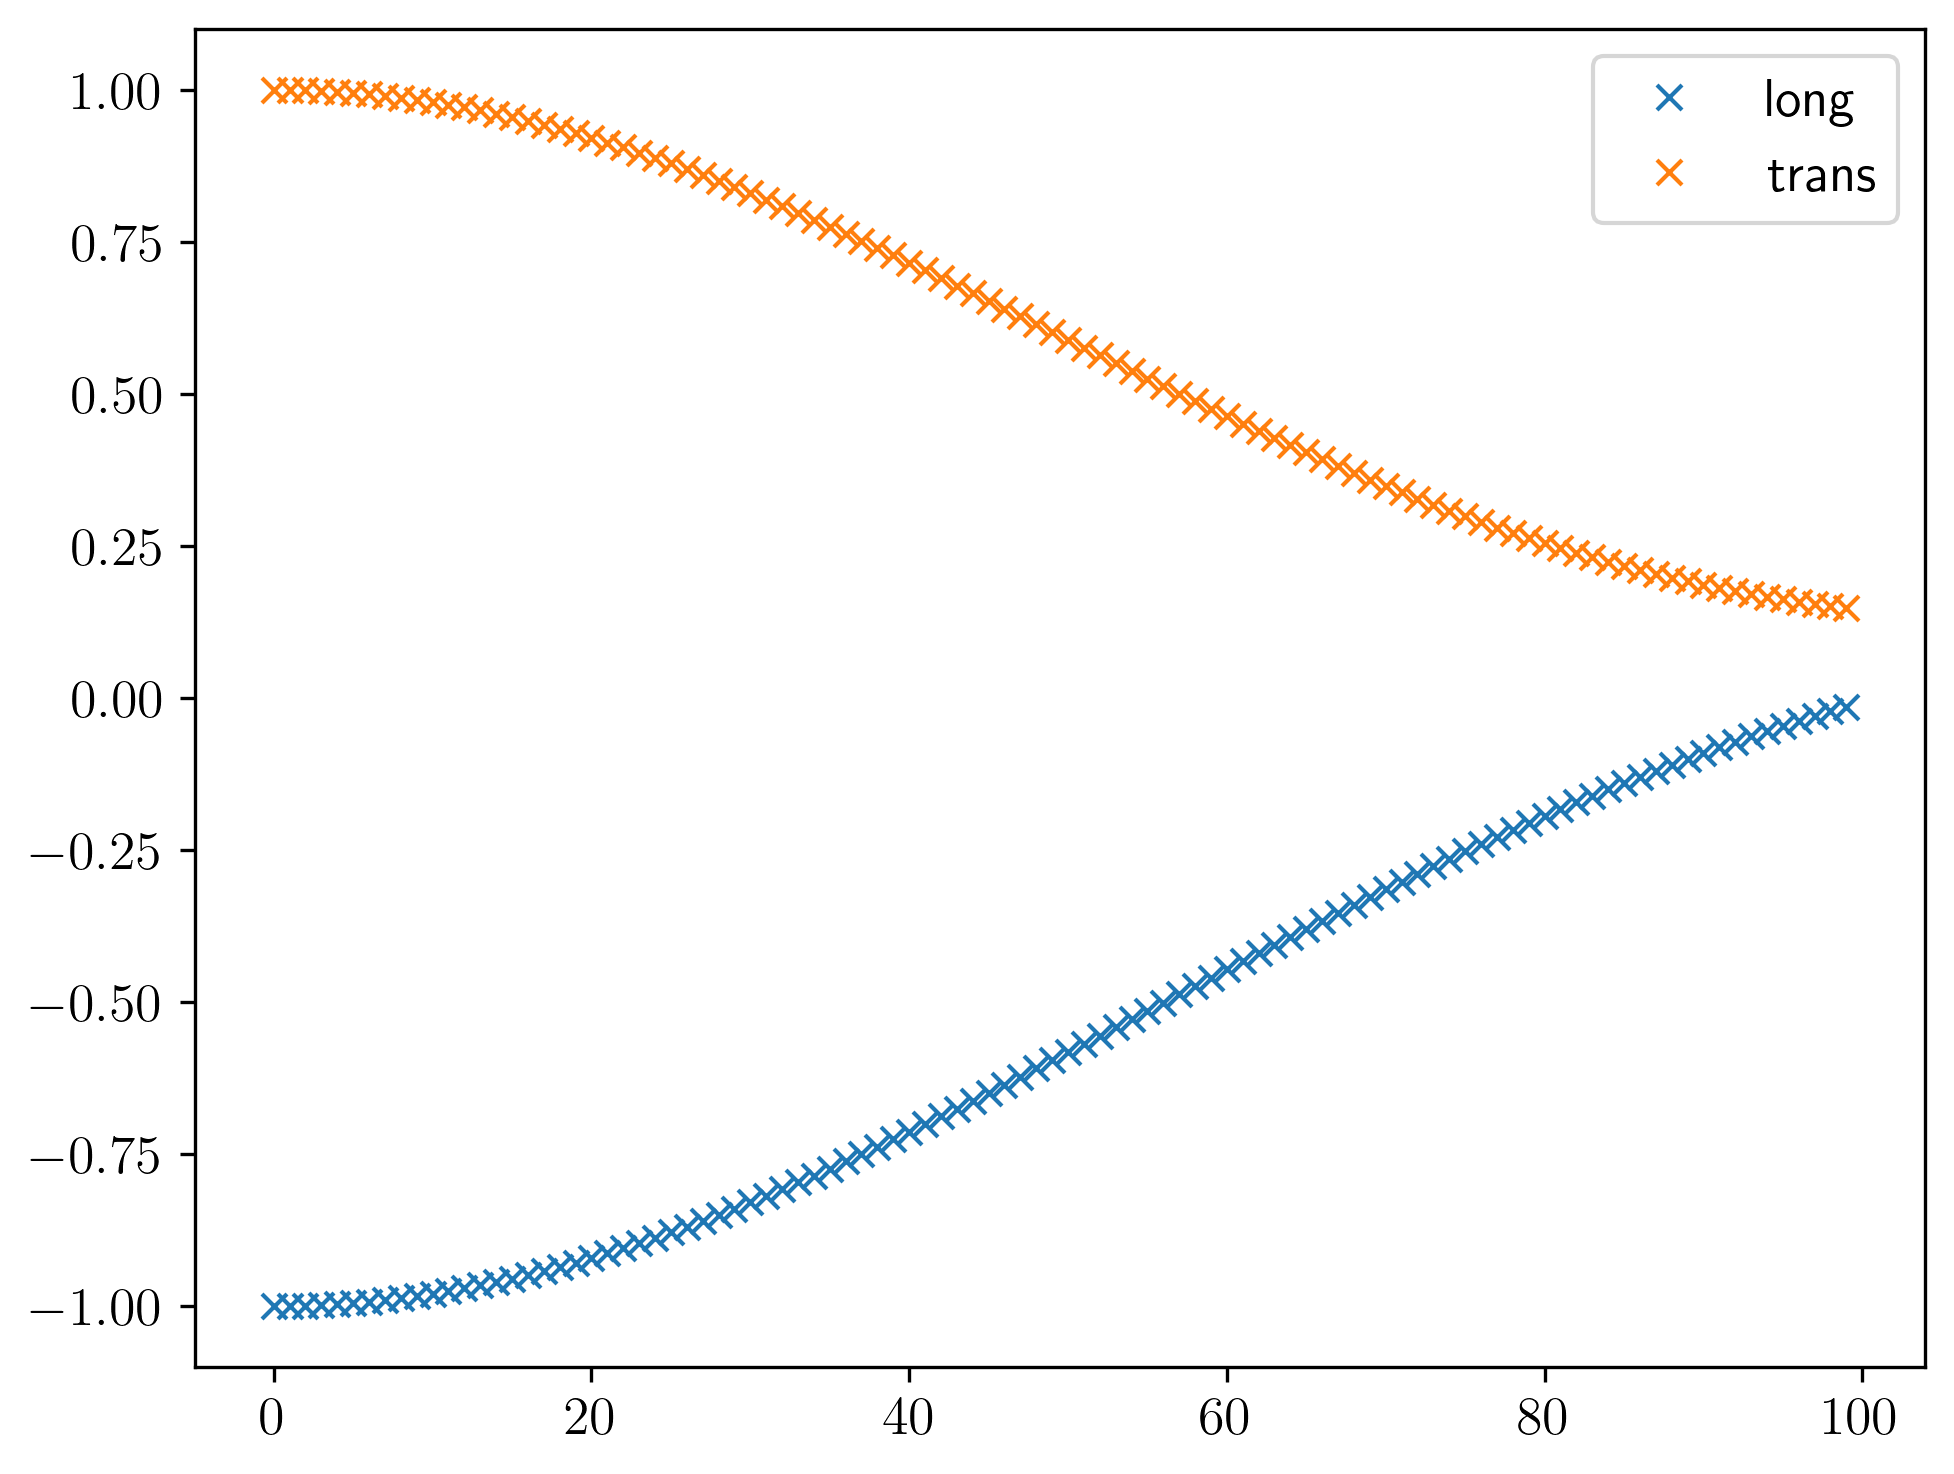

In [179]:
plt.plot([np.mean(e_field[i][0][1::2][cx[0]:cx[1]]) for i in range(steps)], 'x', label="long")
plt.plot([np.mean(e_field[i][1::2,0::2], axis=0)[(L+1)//2] for i in range(steps)], 'x', label="trans")
plt.legend()

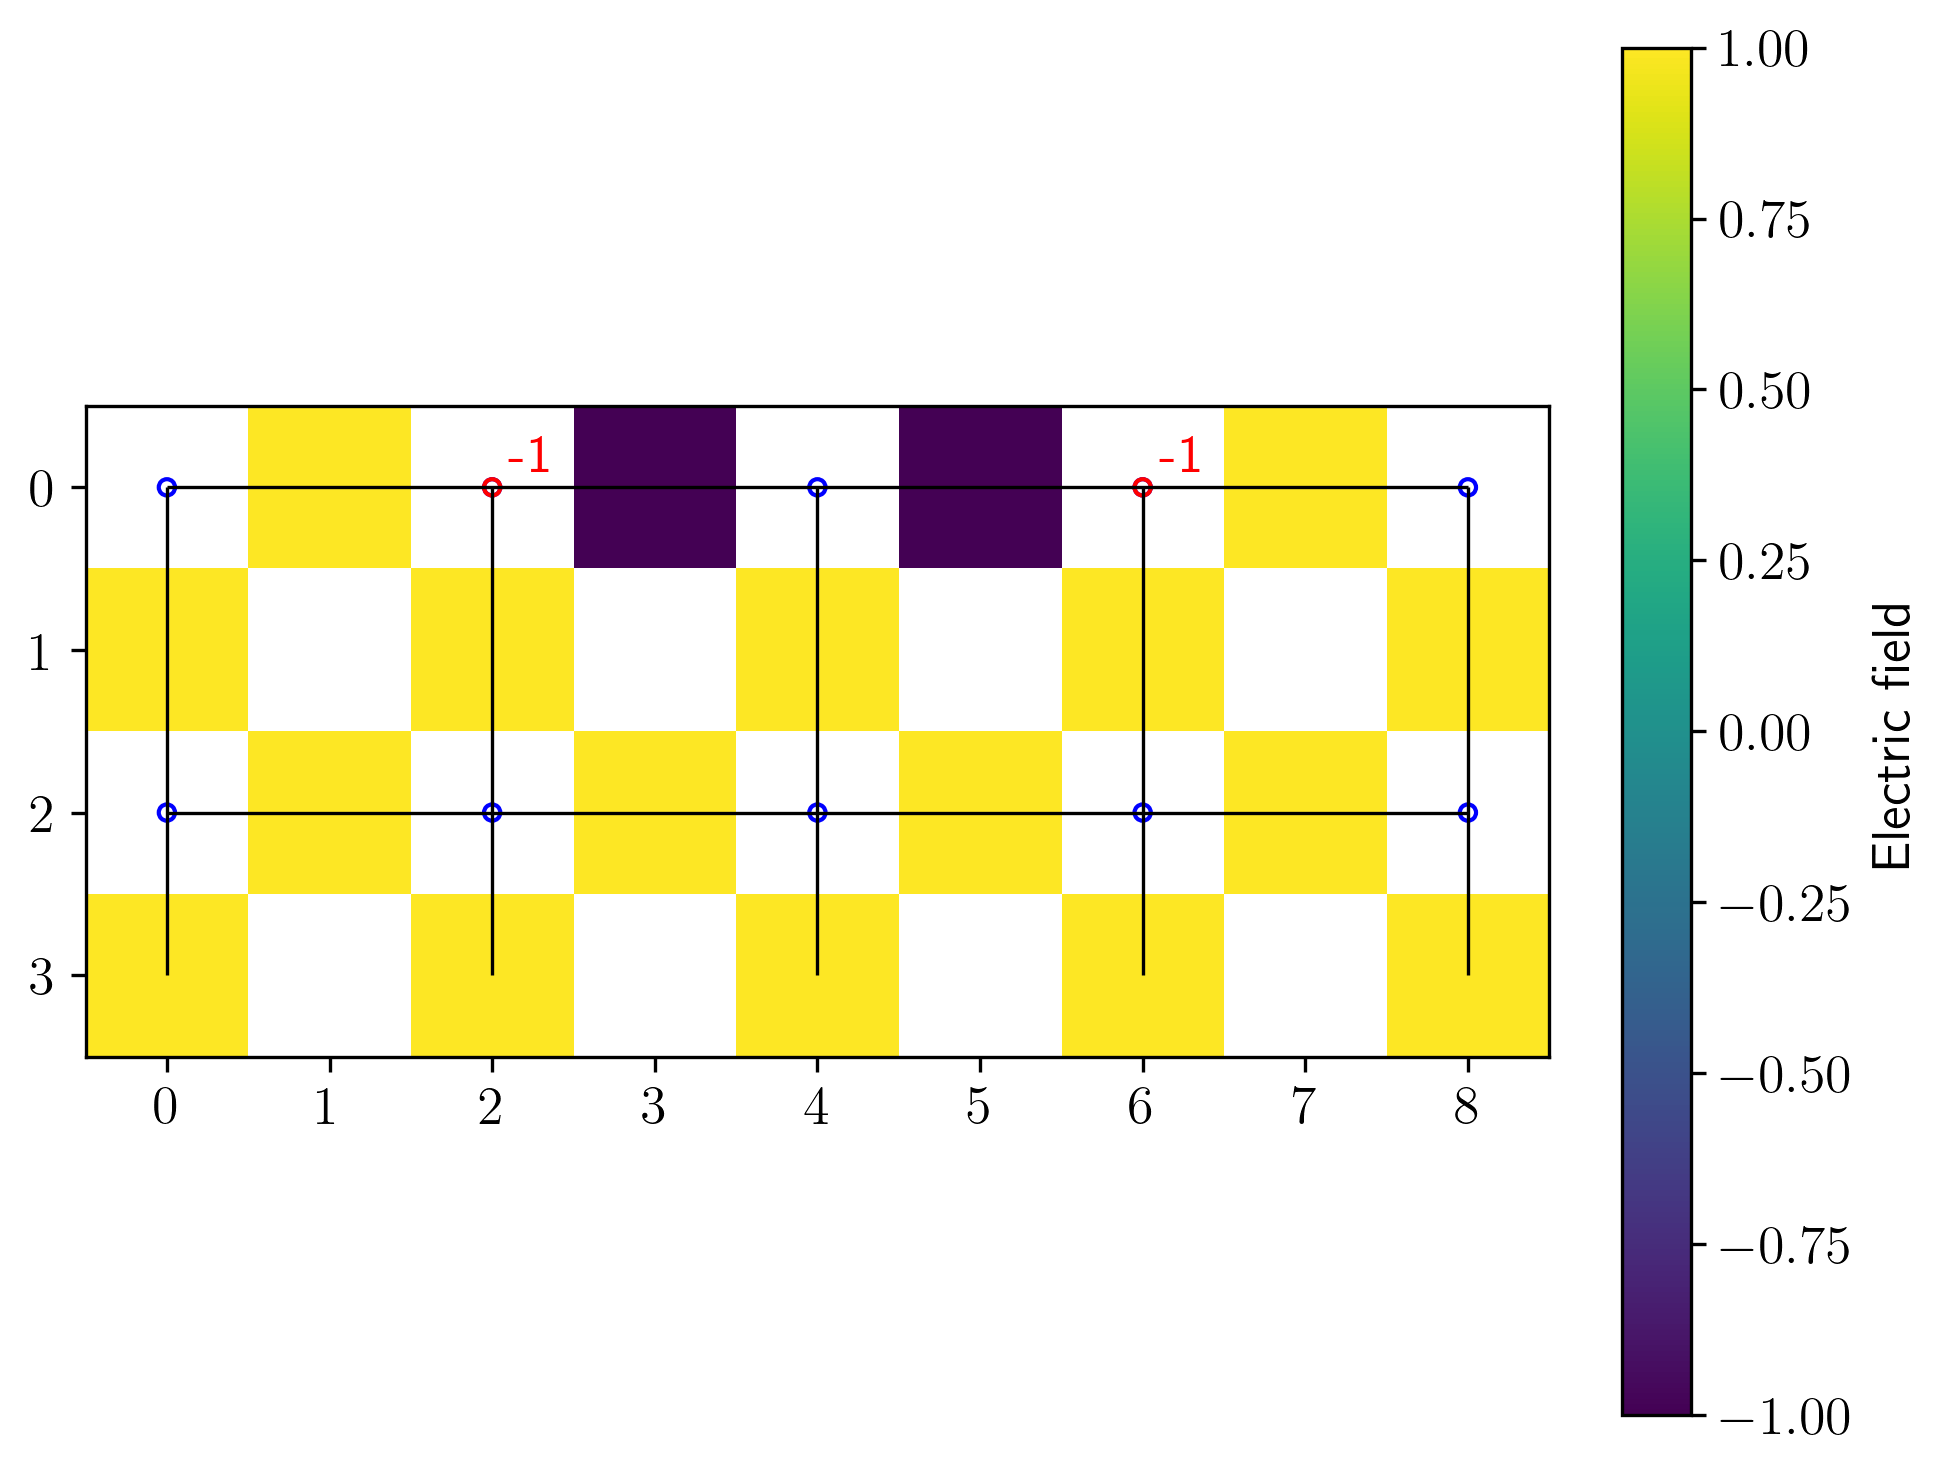

In [178]:
movie = anim(frames=steps+1, interval=200, data=e_field, params=np.linspace(0,steps*delta,steps+1), show=True, charges_x=cx, charges_y=cy, precision=2, time=True)
movie.save(filename="quench_tebd_test_1.gif")

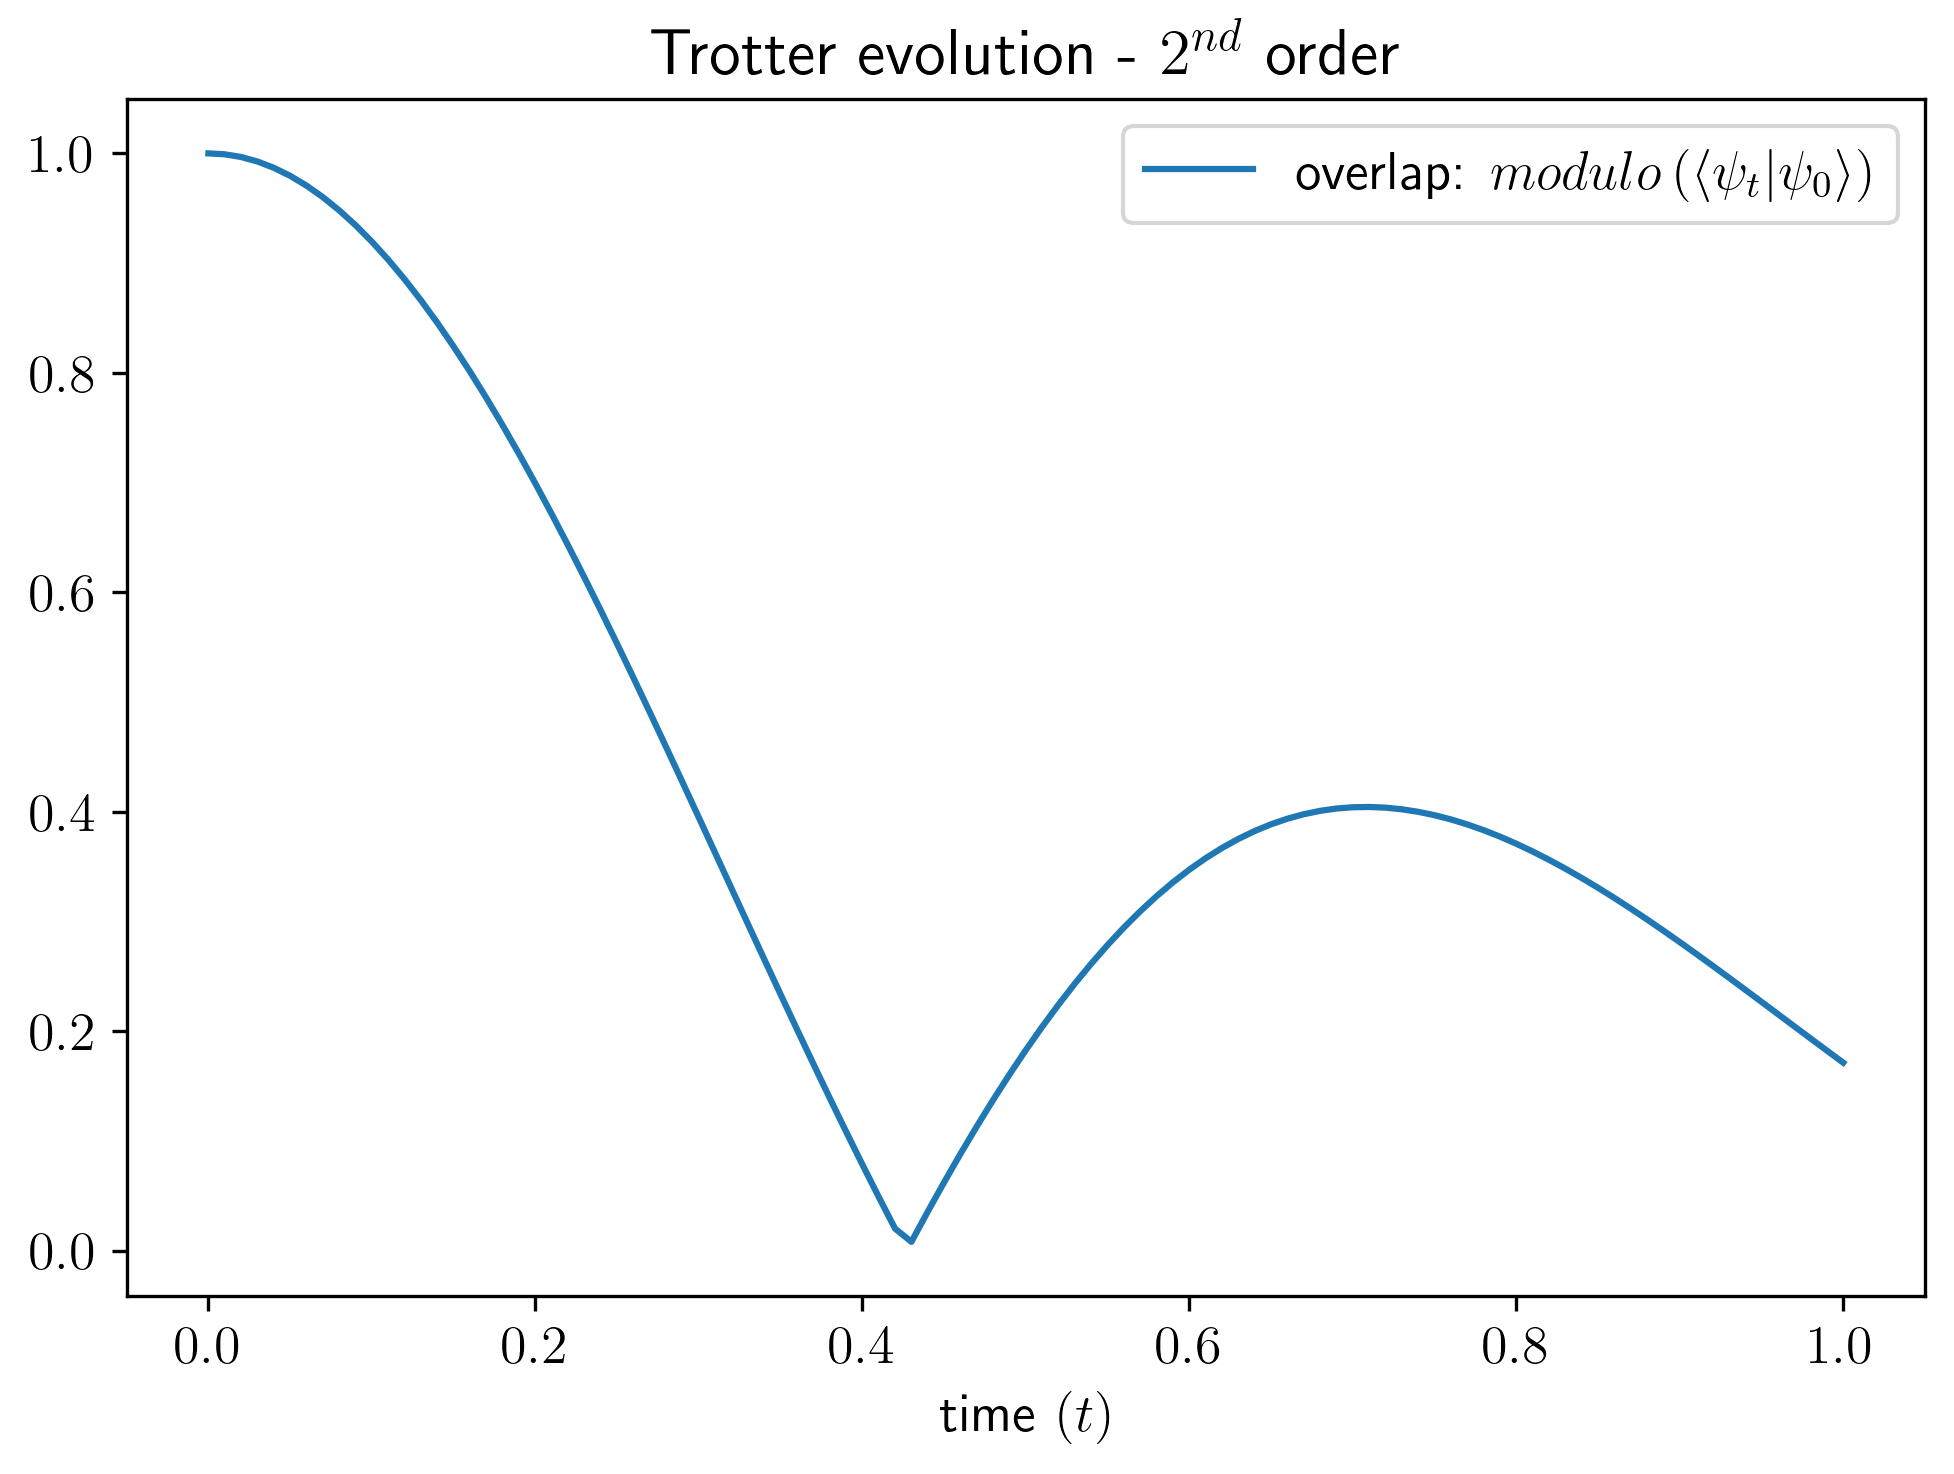

In [180]:
plt.plot(delta*np.asarray(range(steps+1)),[np.sqrt(ov.real**2 + ov.imag**2) for ov in overlap], label="overlap: $modulo \\left(\\langle \\psi_t | \\psi_0 \\rangle \\right)$")
plt.title("Trotter evolution - $2^{nd}$ order")
plt.xlabel("time $(t)$")
plt.legend()
plt.show()

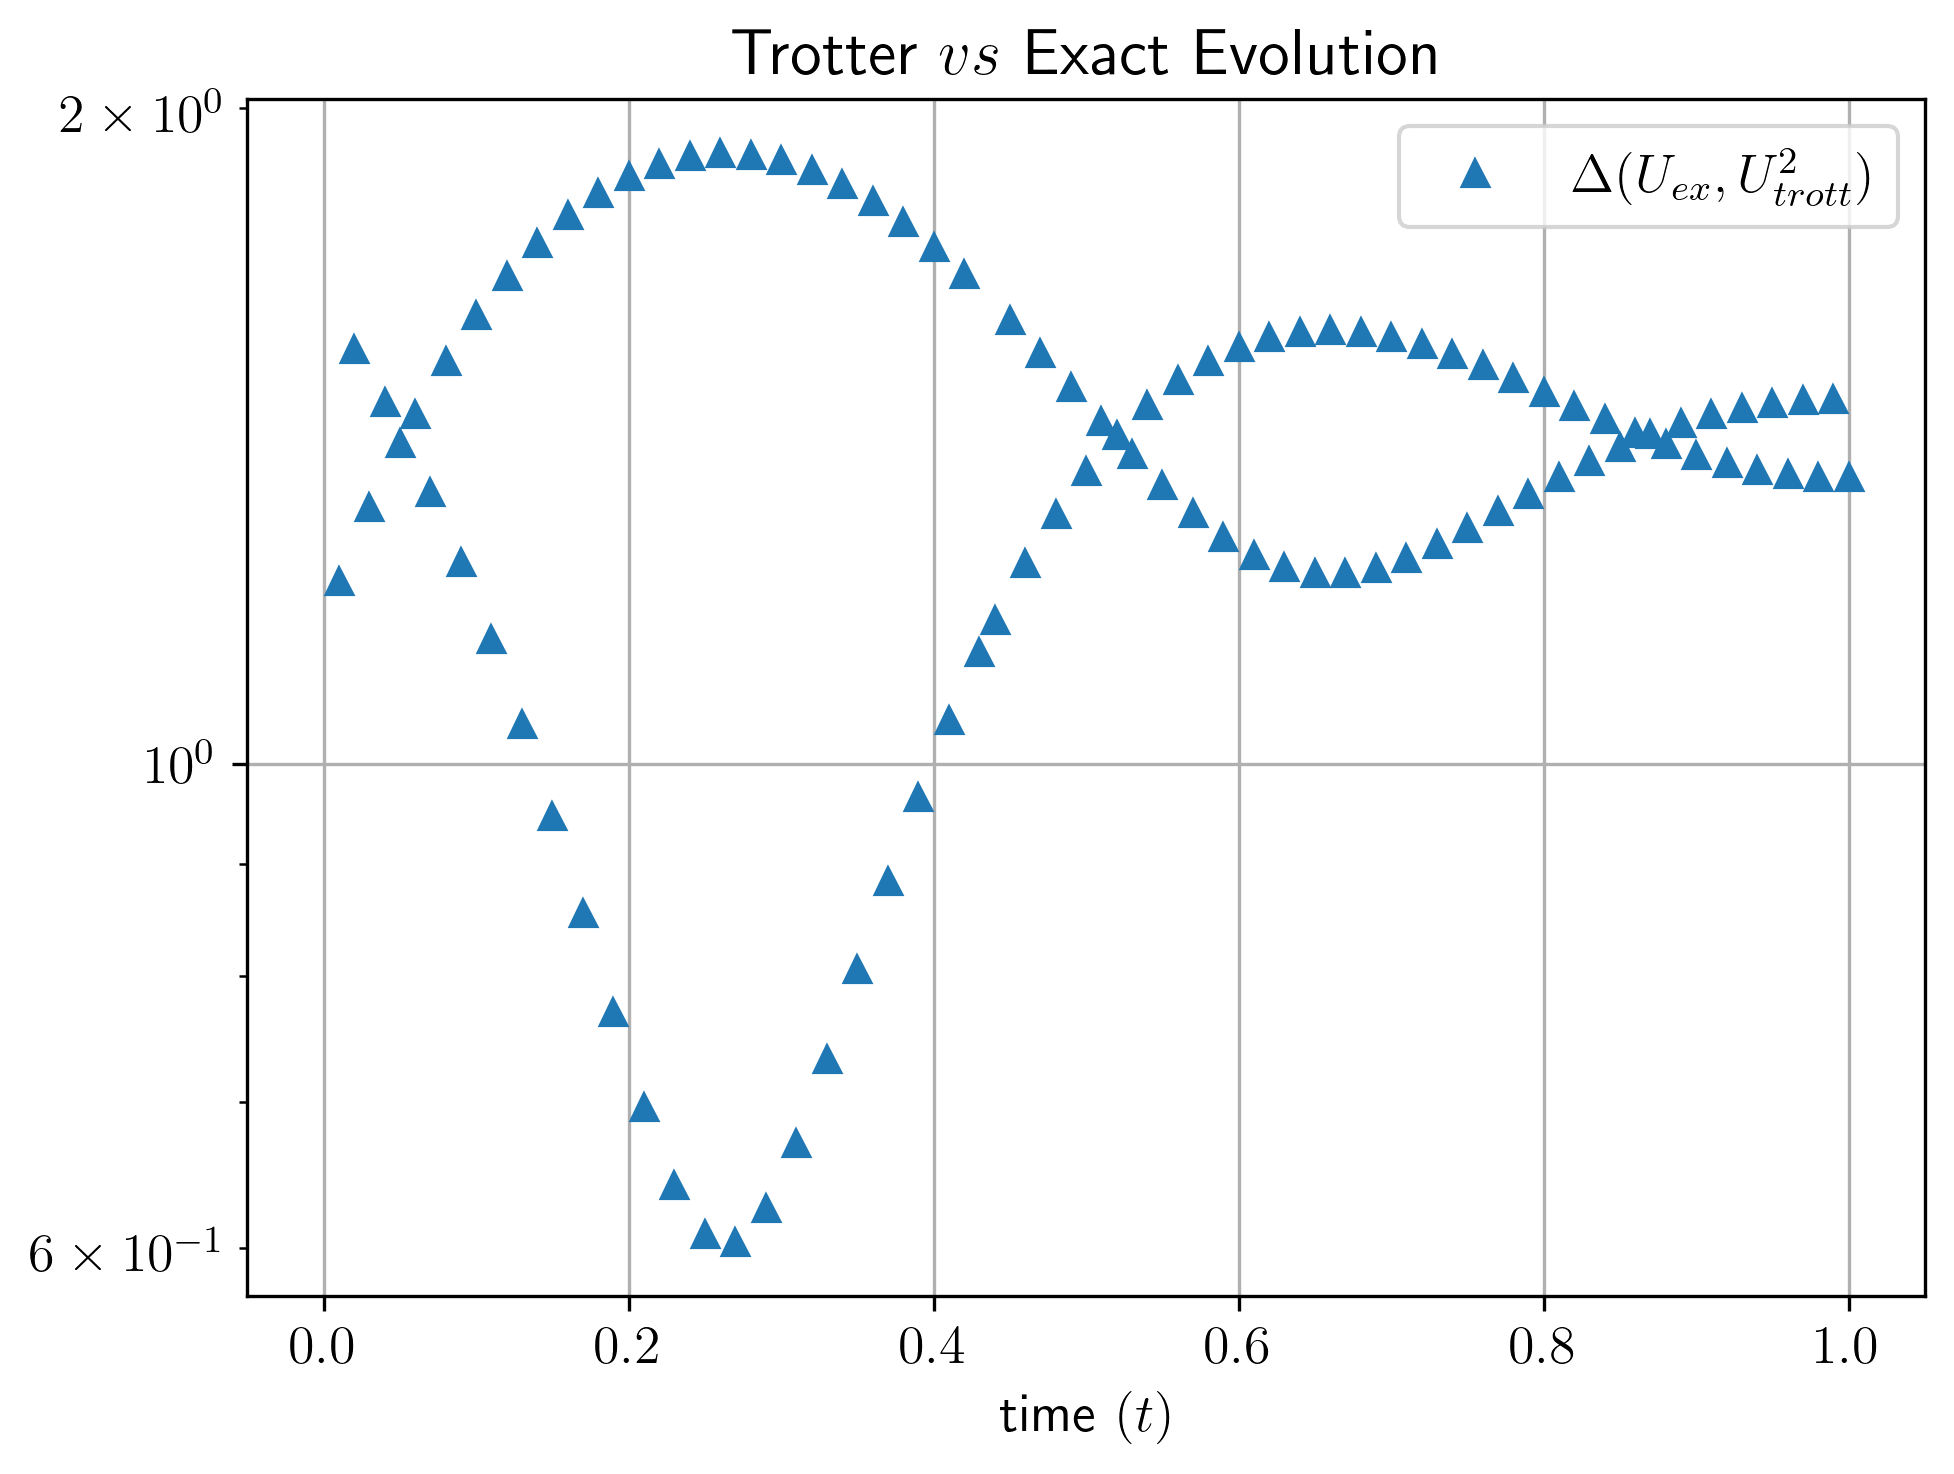

In [181]:
plt.plot(delta*np.asarray(range(steps+1)),trott_err, marker="^", linestyle='', label="$\\Delta (U_{ex},U_{trott}^2)$")
plt.title("Trotter $vs$ Exact Evolution")
plt.xlabel("time $(t)$")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

## 3. Compare MPO and Exact results

In [5]:
l = 2
L = 3
g = 10
R = 1
bc = "pbc"
cx = get_cx(L=L,R=R)
cy = get_cy(l=L, bc=bc)
chi = 32
mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=g, bc=bc)
mps._random_state(seed=3,type_shape="rectangular",chi=chi)
mps.canonical_form()
mps.Z2.add_charges(cx,cy)
mps.charges = mps.Z2.charges
mps.Z2._define_sector()
a = np.zeros((1,2))
a[0,0] = 1
extra_ancillary_site = a.reshape((1,2,1))
mps.sites.append(extra_ancillary_site)
mps.L = len(mps.sites)
mps.DMRG(trunc_chi=True, trunc_tol=False, where=L//2)
tensor_shapes(mps.sites)

Sweep n: 0

Sweep n: 1

(1, 4, 4)
(4, 4, 4)
(4, 4, 1)
(1, 2, 1)


[(1, 4, 4), (4, 4, 4), (4, 4, 1), (1, 2, 1)]

In [12]:
l = 2
L = 3
R = 1
bc = "pbc"
g = 10
cx = get_cx(L=L,R=R)
cy = get_cy(l=l,bc=bc)
H_sc = dual_ham(l,L,g,cx,cy)
e, psi0 = diagonalization(H_sc, sparse=True)
print(len(e),psi0.shape, type(psi0), e)
psi0 = psi0[:,0]

1 (128, 1) <class 'numpy.ndarray'> [-120.001]


In [14]:
mps0 = mps_to_vector(mps.sites)
mps0.shape

(128,)

In [17]:
np.sqrt((mps0 @ psi0).real**2 + (mps0 @ psi0).imag**2)

0.9999999999926756

In [133]:
g_ev = 1
mps.Z2.mpo_Z2_ladder_quench_int(delta=delta, h_ev=g_ev, l=0)
mps.w = mps.Z2.mpo
mat0 = mpo_to_matrix(mps.w.copy())

mps.Z2.mpo_Z2_ladder_quench_int(delta=delta, h_ev=g_ev, l=1)
mps.w = mps.Z2.mpo
mat1 = mpo_to_matrix(mps.w.copy())

mat_mpo = mat0 @ mat1

In [135]:
U_trott2 = trott_Z2_dual(l, L, cx, cy, delta, coupling=g_ev, ord=2)

In [136]:
(U_trott2.conjugate().T @ mat_mpo)[2]

array([ 9.96544661e-05-4.99255025e-03j,  0.00000000e+00+0.00000000e+00j,
        9.99900064e-01-1.19916031e-05j,  0.00000000e+00+0.00000000e+00j,
       -2.49379188e-05+3.99660082e-06j,  0.00000000e+00+0.00000000e+00j,
       -1.00034138e-04-5.00053996e-03j,  0.00000000e+00+0.00000000e+00j,
       -2.49579414e-05+8.99030538e-10j,  0.00000000e+00+0.00000000e+00j,
        9.99142109e-05-4.99654306e-03j,  0.00000000e+00+0.00000000e+00j,
        2.74523768e-08+1.23816685e-07j,  0.00000000e+00+0.00000000e+00j,
       -2.50178899e-05+9.99550325e-07j,  0.00000000e+00+0.00000000e+00j,
       -2.49379742e-05+1.19819304e-09j,  0.00000000e+00+0.00000000e+00j,
       -9.99542053e-05-4.99254166e-03j,  0.00000000e+00+0.00000000e+00j,
        2.47541890e-09+1.25315005e-07j,  0.00000000e+00+0.00000000e+00j,
       -2.48780187e-05-2.99595235e-06j,  0.00000000e+00+0.00000000e+00j,
       -7.47870074e-09+1.25015592e-07j,  0.00000000e+00+0.00000000e+00j,
       -2.49979197e-05-1.99860027e-06j,  0.00000000

In [166]:
l = 2
L = 3
R = 1
bc = "pbc"
cx = get_cx(L,R)
cy = get_cy(l,bc)
g_ev = 0.1
H_ev_el = electric_dual_ham(l, L, cx, cy) # zz dual interaction term
H_ev_mag = magnetic_dual_ham(l, L)
U_loc = evolution_operator(delta=(delta/2)*(-1/g_ev), hamiltonian=H_ev_mag)
U_int = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_ev_el)
print(U_loc.shape)

mps = MPS(L=L,d=2**l, model="Z2_dual", bc=bc)
mps.Z2._initialize_finalize_quench_local(delta, g_ev)
mps.w = mps.Z2.mpo.copy()
mps.w.append(np.array([[np.eye(2)]]))
tensor_shapes(mps.w)
mat_loc = mpo_to_matrix(mps.w.copy())
print(mat_loc.shape)

(128, 128)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 4, 4)
(1, 1, 2, 2)
(128, 128)


In [185]:
(U_loc.conjugate().T @ csc_array(mat_loc)).nonzero()

(array([  0,   0,   0, ..., 127, 127, 127], dtype=int32),
 array([126, 124, 122, ...,   7,   5,   1], dtype=int32))

In [186]:
from qs_mps.checks import check_matrix

check_matrix(U_loc, csr_matrix(mat_loc))

4.2045624878121017e-16

In [169]:
mps = MPS(L=L,d=2**l, model="Z2_dual", bc=bc)
mps.Z2.mpo_Z2_ladder_quench_int(delta, g_ev, l=0)
mps.w = mps.Z2.mpo.copy()
tensor_shapes(mps.w)
mat_int0 = mpo_to_matrix(mps.w.copy())
print(mat_int0.shape)

mps.Z2.mpo_Z2_ladder_quench_int(delta, g_ev, l=1)
mps.w = mps.Z2.mpo.copy()
tensor_shapes(mps.w)
mat_int1 = mpo_to_matrix(mps.w.copy())
print(mat_int1.shape)

mat_int = mat_int0 @ mat_int1

(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)
(128, 128)
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 2, 2)
(128, 128)


In [184]:
(U_int.conjugate().T @ csc_array(mat_int)).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46

In [171]:
check_matrix(U_int, csr_matrix(mat_int))

    ERROR: A and B are DIFFERENT MATRICES


ValueError:     NORM 0.055425394903085325, RATIO 0.00244948688503006

## Debug interaction terms

In [359]:
from qs_mps.mpo_class import MPO_ladder as MPO

delta = 0.01
g_ev = 0.7
l = 2
L = 3
bc = "pbc"
R = 1
cx = get_cx(L,R)
cy = get_cy(l,bc)
dof = l*L + 1
O = csc_array((2**dof, 2**dof), dtype=complex)
Ol = csc_array((2**l, 2**l), dtype=complex)
I = identity(2**l, dtype=complex).toarray()

# charges
charges = np.ones((l,L+1))
if cx is not None:
    charges[cy[0],cx[0]] = -1
    charges[cy[1],cx[1]] = -1

prod_charges = np.prod(charges, axis=1).tolist()


### Debug vertical left links

In [360]:
H_sigmas = O
# first column of sigmas are local
for j in range(l):
    H_sigmas += sparse_pauli_z(n=j*L, L=dof)

U_vel = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_sigmas)

In [361]:
matrix_mpo = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo.shape)
for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        
        mpo_lad = MPO(l=l, L=L, model="Z2_dual", bc="pbc")
        mpo_lad.mpo_skeleton(aux_dim=2)
        if mpo_site == 0:
            # vertical links left edge - local and even terms
            w_loc_le = expm(1j * g_ev * delta * Z)
            mpo_lad.mpo[0,-1] = w_loc_le

        w_tot.append(mpo_lad.mpo.copy())
    
    I2 = np.eye(2)
    O2 = np.zeros((2,2))
    w_l = np.array([[O2],[I2]])
    w_tot.append(w_l)
    matrix_lad = mpo_to_matrix(w_tot)
    print(matrix_lad)
    matrix_mpo = matrix_mpo @ matrix_lad

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
[[0.9999755+0.00699994j 0.       +0.j         0.       +0.j         ...
  0.       +0.j         0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.9999755+0.00699994j 0.       +0.j         ...
  0.       +0.j         0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.9999755+0.00699994j ...
  0.       +0.j         0.       +0.j         0.       +0.j        ]
 ...
 [0.       +0.j         0.       +0.j         0.       +0.j         ...
  0.9999755-0.00699994j 0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.       +0.j         ...
  0.       +0.j         0.9999755-0.00699994j 0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.       +0.j         ...
  0.       +0.j         0.       +0.j         0.9999755-0.00699994j]]
site: 0, ladder: 1
site: 1, ladder: 1
site: 2, ladder: 1
[[0.9999755+0.00699994j

In [362]:
(U_vel.conjugate().T @ matrix_mpo).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

### Debug horizontal bulk links

In [363]:
H_taus = O
# vertical zz interactions 
for i in range(L):
    for j in range(l):
        # coeff = charge_func(i,j,l,cx,cy)
        # H_taus += coeff * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)
        H_taus += np.prod(charges[(j+1)%l,:(i+1)]) * sparse_pauli_z(n=j*L+i, L=dof) @ sparse_pauli_z(n=((j+1)%l)*L+i, L=dof)

U_hob = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_taus)

In [364]:
matrix_mpo = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo.shape)

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        
        mpo_lad = MPO(l=l, L=L, model="Z2_dual", bc="pbc")
        mpo_lad.mpo_skeleton(aux_dim=2)
        # horizontal links bulk - local terms
        coeff = np.prod(mpo_lad.charges[(lad + 1) % mpo_lad.l, : mpo_site + 1])
        Z_ll = coeff * (
            sparse_pauli_z(n=lad, L=mpo_lad.l) @ sparse_pauli_z(n=(lad + 1) % mpo_lad.l, L=mpo_lad.l)
        ).toarray()
        w_int_loc = expm(1j * g_ev * delta * Z_ll)
        mpo_lad.mpo[0,-1] = w_int_loc
        
        w_tot.append(mpo_lad.mpo.copy())
    
    I2 = np.eye(2)
    O2 = np.zeros((2,2))
    w_l = np.array([[O2],[I2]])
    w_tot.append(w_l)
    matrix_lad = mpo_to_matrix(w_tot)
    print(matrix_lad)
    matrix_mpo = matrix_mpo @ matrix_lad

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
[[2.9999265+0.02099983j 0.       +0.j         0.       +0.j         ...
  0.       +0.j         0.       +0.j         0.       +0.j        ]
 [0.       +0.j         2.9999265+0.02099983j 0.       +0.j         ...
  0.       +0.j         0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.       +0.j         2.9999265+0.00699994j ...
  0.       +0.j         0.       +0.j         0.       +0.j        ]
 ...
 [0.       +0.j         0.       +0.j         0.       +0.j         ...
  2.9999265+0.00699994j 0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.       +0.j         ...
  0.       +0.j         2.9999265+0.02099983j 0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.       +0.j         ...
  0.       +0.j         0.       +0.j         2.9999265+0.02099983j]]
site: 0, ladder: 1
site: 1, ladder: 1
site: 2, ladder: 1
[[2.9999265+0.02099983j

In [365]:
(U_hob.conjugate().T @ matrix_mpo).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

### Debug vertical right links

In [368]:
H_sigmas = O
# horizontal zz interactions, last column of sigmas
for j in range(l):
    # H_sigmas += sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)
    H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

U_ver = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_sigmas)

In [369]:
matrix_mpo = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo.shape)

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        
        mpo_lad = MPO(l=l, L=L, model="Z2_dual", bc="pbc")
        mpo_lad.mpo_skeleton(aux_dim=2)
        if mpo_site == L-1:
            coeff = np.prod(prod_charges[: lad + 1])
            w_even_re = np.array(
                            [
                                [
                                    np.sqrt(np.cos(np.abs(coeff) * g_ev * delta)) * I,
                                    1j
                                    * np.sign(coeff)
                                    * np.sqrt(np.sin(np.abs(coeff) * g_ev * delta))
                                    * Z,
                                ],
                                [
                                    Ol.toarray(),
                                    Ol.toarray(),
                                ]
                            ]
                        )
            print(w_even_re.shape)
            w_tot.append(w_even_re)
        else:
            w_tot.append(mpo_lad.mpo.copy())
    
    # vertical links right edge - odd term (ancillary site)
    coeff = np.prod(prod_charges[: lad + 1])
    Z2 = sparse_pauli_z(n=0, L=1).toarray()
    I2 = identity(2, dtype=complex).toarray()
    O2 = csc_array((2, 2), dtype=complex).toarray()
    w_odd_re = np.array(
            [
                [   O2,
                    np.sqrt(np.cos(np.abs(coeff) * g_ev * delta)) * I2,
                ],
                [   O2,
                    np.sqrt(np.sign(coeff) * np.sin(np.abs(coeff) * g_ev * delta)) * Z2,
                ]
            ]
        )
    # w_l = np.swapaxes(w_odd_re, axis1=0, axis2=1)
    w_tot.append(w_l)
    matrix_lad = mpo_to_matrix(w_tot)
    matrix_mpo = matrix_mpo @ matrix_lad

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
(2, 2, 4, 4)
site: 0, ladder: 1
site: 1, ladder: 1
site: 2, ladder: 1
(2, 2, 4, 4)


In [370]:
(U_ver.conjugate().T @ matrix_mpo).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  

### Debug vertical bulk links

In [371]:
H_sigmas = O
# horizontal zz interactions, we exclude the last column of sigmas
for j in range(l):
    for i in range(L-1):
        H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

U_veb = evolution_operator(delta=delta*(-g_ev), hamiltonian=H_sigmas)

In [374]:
matrix_mpo = identity(2**dof, dtype=complex).toarray()
print(matrix_mpo.shape)

for lad in range(l):
    w_tot = []
    for mpo_site in range(L):
        print(f"site: {mpo_site}, ladder: {lad}")
        Z = sparse_pauli_z(n=lad, L=l).toarray()
        w_even = np.array(
                [
                    [
                        np.sqrt(np.cos(g_ev * delta)) * I,
                        1j
                        * np.sqrt(np.sin(g_ev * delta))
                        * Z,
                    ]
                ]
            )
        w_odd = np.array(
                [
                    [
                        np.sqrt(np.cos(g_ev * delta)) * I,
                        np.sqrt(np.sin(g_ev * delta)) * Z,
                    ]
                ]
            )
        w_odd = np.swapaxes(w_odd, axis1=0, axis2=1)

        if mpo_site == 0:
            w_tot.append(w_even)
        if mpo_site == L-1:
            w_tot.append(w_odd)
        else:
            w_l = ncon(
                    [w_even, w_odd],
                    [[-1, -3, -5, 1], [-2, -4, 1, -6]],
                ).reshape(
                        (
                            w_even.shape[0] * w_odd.shape[0],
                            w_even.shape[1] * w_odd.shape[1],
                            w_even.shape[2],
                            w_odd.shape[-1],
                        )
                    )
            w_tot.append(w_l)
    
    I2 = np.eye(2)
    O2 = np.zeros((2,2))
    w_l = np.array([[I2]])

    w_tot.append(w_l)
    tensor_shapes(w_tot)
    matrix_lad = mpo_to_matrix(w_tot)
    matrix_mpo = matrix_mpo @ matrix_lad

(128, 128)
site: 0, ladder: 0
site: 1, ladder: 0
site: 2, ladder: 0
(1, 2, 4, 4)
(2, 2, 4, 4)
(2, 2, 4, 4)
(2, 1, 4, 4)
(1, 1, 2, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 512 is different from 128)

In [ ]:
(U_veb.conjugate().T @ matrix_mpo).nonzero()